In [1]:
import uproot
import h5py
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict
from scipy import integrate

In [2]:
# def printattr(name, object):
#     print(name)
# h5py_file = h5py.File('ttbar_testing/ttbar_testing_170_gev.h5', "r")
# h5py_file.visititems(printattr)

In [3]:
# Fixed the bins, colors, mass arr, and labels for all plots.
bins_min, bins_max, bins_w = 120, 230, 1
bins = np.arange(bins_min, bins_max+1, bins_w)
bins_dense = np.linspace(bins_min, bins_max, 1000)

mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)
top_mass_chi2 = np.linspace(166, 180, 1000)

loglikeli_cut = -75
marginal_prob_cut = 0.2

tot_event = 10000
N = 1000
sudo_bins = np.arange(166, 180, 0.2)
sudo_bins_dense = np.linspace(166, 180, 1000)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
state_labels = ['Unmatched', 'Incorrect', 'Correct']
langau_fit_labels = ['Mean of Landau', 'Variance of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']
two_gau_fit_labels = ['Mean of  first Gaussian', 'Variance of first Gaussian', 'Mean of  second Gaussian', 'Variance of second Gaussian', 'Fraction of second Gaussian']

In [4]:
def get_reco_top_mass(h5py_file, target): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)*JSF
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    100 < reco_m_top < 300
    additional cuts (same as CMS)
    """
    # Caululate delR
    # Caululate delR
    lepton_eta = h5py_file['lepton_features/eta'][:]
    lepton_phi = h5py_file['lepton_features/phi'][:]
    jet_eta = h5py_file['jet_features/eta'][:]
    jet_phi = h5py_file['jet_features/phi'][:]
    del_eta = np.array([jet_eta[i, :4] - lepton_eta[i] for i in range(len(jet_eta))])
    del_phi = np.abs([jet_phi[i, :4] - lepton_phi[i] for i in range(len(jet_eta))])
    del_phi = np.where(del_phi < np.pi, del_phi, 2*np.pi-del_phi)
    delR = np.sqrt(del_eta**2 + del_phi**2)

    # cuts
    # pid 11 is electron, 13 is muon.
    cut_reco_top = np.logical_and(dic['reconstructed_top_mass'] > 100, dic['reconstructed_top_mass'] < 300)
    cut_lepton_pt = np.logical_or(
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 26, h5py_file['lepton_features/pid'][:] == 13),
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 29, h5py_file['lepton_features/pid'][:] == 11))
    cut_lepton_eta = np.abs(h5py_file['lepton_features/eta'][:]) < 2.4
    cut_delR = np.logical_or(np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 13, delR[:, 0] > 0.4, delR[:, 1] > 0.4, delR[:, 2] > 0.4, delR[:, 3] > 0.4)),
            np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 11, delR[:, 0] > 0.3, delR[:, 1] > 0.3, delR[:, 2] > 0.3, delR[:, 3] > 0.3)))
    cut_jet_pt = h5py_file['jet_features/pt'][:, 3] > 30
    cut_jet_eta = np.logical_and.reduce((abs(h5py_file['jet_features/eta'][:, 0]) < 2.4, abs(h5py_file['jet_features/eta'][:, 1]) < 2.4,
                                        abs(h5py_file['jet_features/eta'][:, 2]) < 2.4, abs(h5py_file['jet_features/eta'][:, 3]) < 2.4))
    cut_first4_btag = np.sum(h5py_file['jet_features/btag'][:, :4], axis=1) == 2
    cuts_CMS = np.logical_and.reduce((cut_lepton_pt, cut_lepton_eta, cut_delR, cut_jet_pt, cut_jet_eta, cut_first4_btag))
    cuts = np.logical_and.reduce((cut_reco_top, cut_lepton_pt, cut_lepton_eta, cut_delR, cut_jet_pt, cut_jet_eta, cut_first4_btag))

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], state, [True]*len(cuts), h5py_file['klfitter/score/loglikelihood'][:]
    elif target == 'spanet': return dic['reconstructed_top_mass'], state, [True]*len(cuts), h5py_file['spanet/right_target/assignment_probability'][:], h5py_file['spanet/right_target/detection_probability'][:], h5py_file['spanet/right_target/marginal_probability'][:]

In [5]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct

reco_spanet_dic, state_spanet_dic, cut_spanet_dic = {}, {}, {}
reco_klf_dic, state_klf_dic, cut_klf_dic = {}, {}, {}
loglikeli_klf_dic, assignment_spanet_dic, detection_spanet_dic, marginal_spanet_dic = {}, {}, {}, {}

for m in mass:
    h5py_file = h5py.File('ttbar_testing/ttbar_testing_{}_gev.h5'.format(m), "r")
    reco_spanet_dic[m], state_spanet_dic[m], cut_spanet_dic[m], assignment_spanet_dic[m], detection_spanet_dic[m], marginal_spanet_dic[m] = get_reco_top_mass(h5py_file, 'spanet')
    h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_{}_gev_with_spanet_KLFitter.h5'.format(m), "r")
    reco_klf_dic[m], state_klf_dic[m], cut_klf_dic[m], loglikeli_klf_dic[m]  = get_reco_top_mass(h5py_file, 'klfitter')

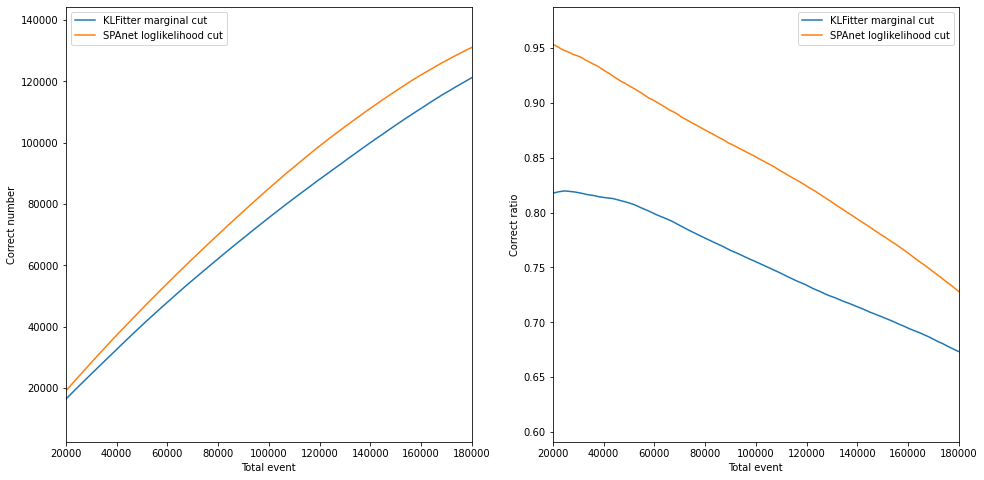

In [6]:
loglikeli_total_event = defaultdict(list)
loglikeli_correct_number = defaultdict(list)

marginal_total_event = defaultdict(list)
marginal_correct_number = defaultdict(list)

m = 173
for cut1 in np.linspace(-80, -60, 100):
    loglikeli_total_event[m].append(len(state_klf_dic[m][np.logical_and(cut_klf_dic[m], loglikeli_klf_dic[m]>cut1)]))
    loglikeli_correct_number[m].append(np.count_nonzero(state_klf_dic[m][np.logical_and(cut_klf_dic[m], loglikeli_klf_dic[m]>cut1)] != 0))

for cut2 in np.linspace(0.1, 0.9, 100):
    marginal_total_event[m].append(len(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], marginal_spanet_dic[m]>cut2)]))
    marginal_correct_number[m].append(np.count_nonzero(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], marginal_spanet_dic[m]>cut2)] != 0))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(loglikeli_total_event[m], loglikeli_correct_number[m], label = 'KLFitter marginal cut')
plt.plot(marginal_total_event[m], marginal_correct_number[m], label = 'SPAnet loglikelihood cut')
plt.xlabel('Total event')
plt.ylabel('Correct number')
plt.legend(loc='upper left')
plt.xlim(20000, 180000)

plt.subplot(1, 2, 2)
plt.plot(loglikeli_total_event[m], np.array(loglikeli_correct_number[m])/loglikeli_total_event[m], label = 'KLFitter marginal cut')
plt.plot(marginal_total_event[m], np.array(marginal_correct_number[m])/marginal_total_event[m], label = 'SPAnet loglikelihood cut')
plt.xlabel('Total event')
plt.ylabel('Correct ratio')
plt.legend(loc='upper right')
plt.savefig('./plots_topmass/cut_comparison')
plt.xlim(20000, 180000)
plt.show()

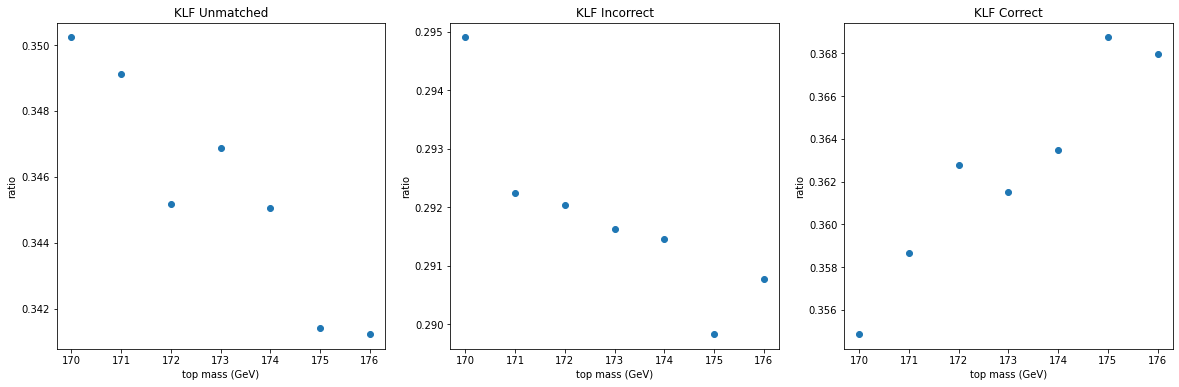

{0: 0.34558731826371636, 1: 0.2918395959187915, 2: 0.36257308581749215}


In [7]:
ratio_klf_dic = defaultdict(list)
for i, m in enumerate(mass):
    for state_i in [0, 1, 2]:
        ratio = np.count_nonzero(state_klf_dic[m][np.logical_and(cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut)]==state_i)/len(state_klf_dic[m][np.logical_and(cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut)])
        ratio_klf_dic[state_i].append(ratio)

plt.figure(figsize=(20, 6))
for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(mass, ratio_klf_dic[state_i])
    plt.title('KLF ' + state_labels[state_i])
    plt.xlabel('top mass (GeV)')
    plt.ylabel('ratio')
plt.savefig('./plots_topmass/klf_ratio.png')
plt.show()
ratio_klf = {key:np.mean(ratio_klf_dic[key]) for key in ratio_klf_dic}
print(ratio_klf)

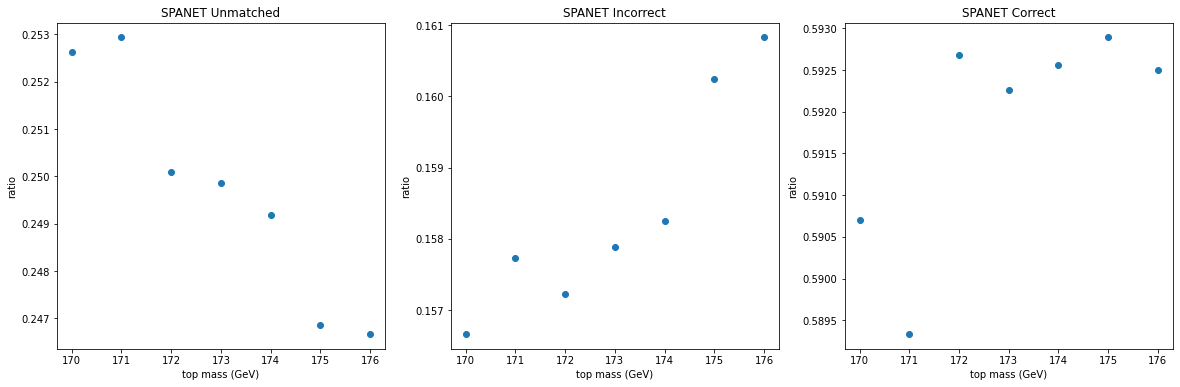

{0: 0.2497460710947481, 1: 0.15840491218962813, 2: 0.5918490167156237}


In [8]:
ratio_spanet_dic = defaultdict(list)
for i, m in enumerate(mass):
    for state_i in [0, 1, 2]:
        ratio = np.count_nonzero(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut)]==state_i)/len(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut)])
        ratio_spanet_dic[state_i].append(ratio)

plt.figure(figsize=(20, 6))
for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(mass, ratio_spanet_dic[state_i])
    plt.title('SPANET ' + state_labels[state_i])
    plt.xlabel('top mass (GeV)')
    plt.ylabel('ratio')
plt.savefig('./plots_topmass/spanet_ratio.png')
plt.show()
ratio_spanet = {key:np.mean(ratio_spanet_dic[key]) for key in ratio_spanet_dic}
print(ratio_spanet)

In [9]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized version
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, bins_min, bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]

# Two gaussian distributions.
def two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    return two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f)/integrate.quad(two_gau, bins_min, bins_max, args=(gau_loc1, gau_scale1, gau_loc2, gau_scale2, f))[0]

# Gaussian distributions.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

# Linear
def linear(x, a, b):
    return a*x+b

def chi2_pdf(observed, pdf): #mt1 is the observation, n2 is the height of the bins from pdf.
    n1, _ = np.histogram(observed, bins=bins)
    n2 = pdf*bins_w*len(observed)
    return np.sum((n1-n2)**2/n2)

def loglikeli_two_gauss(popt, fit_target): return -2*np.sum(np.log(two_gau_norm(fit_target, *popt)))
def loglikeli_langau(popt, fit_target): return -2*np.sum(np.log(langau_norm(fit_target, *popt)))

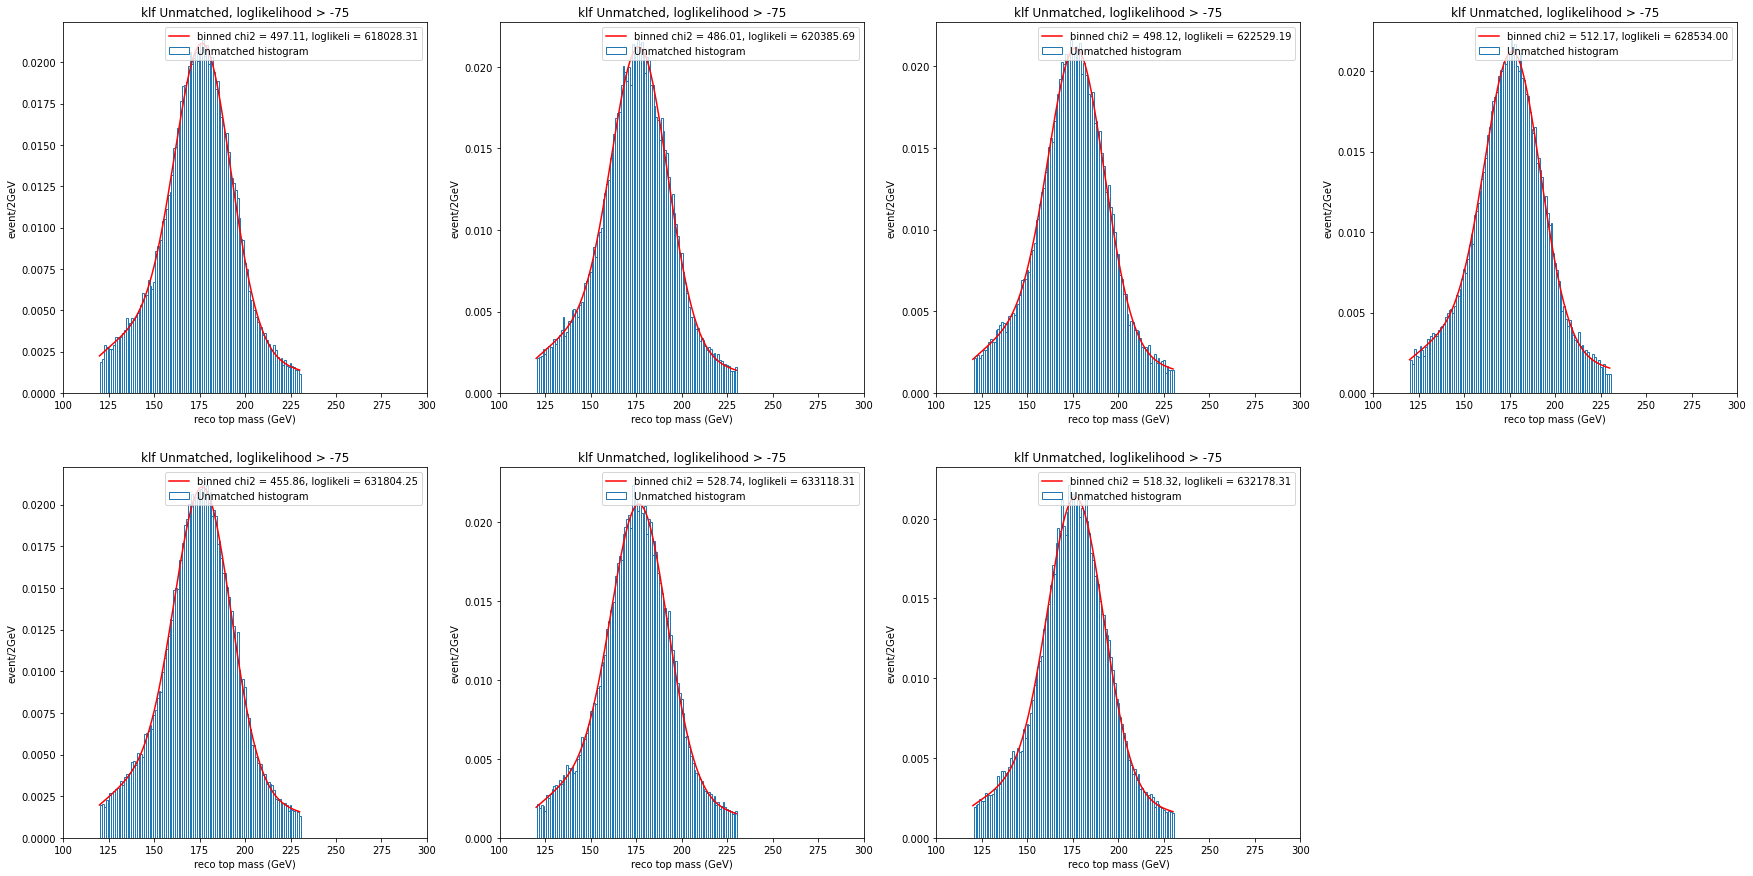

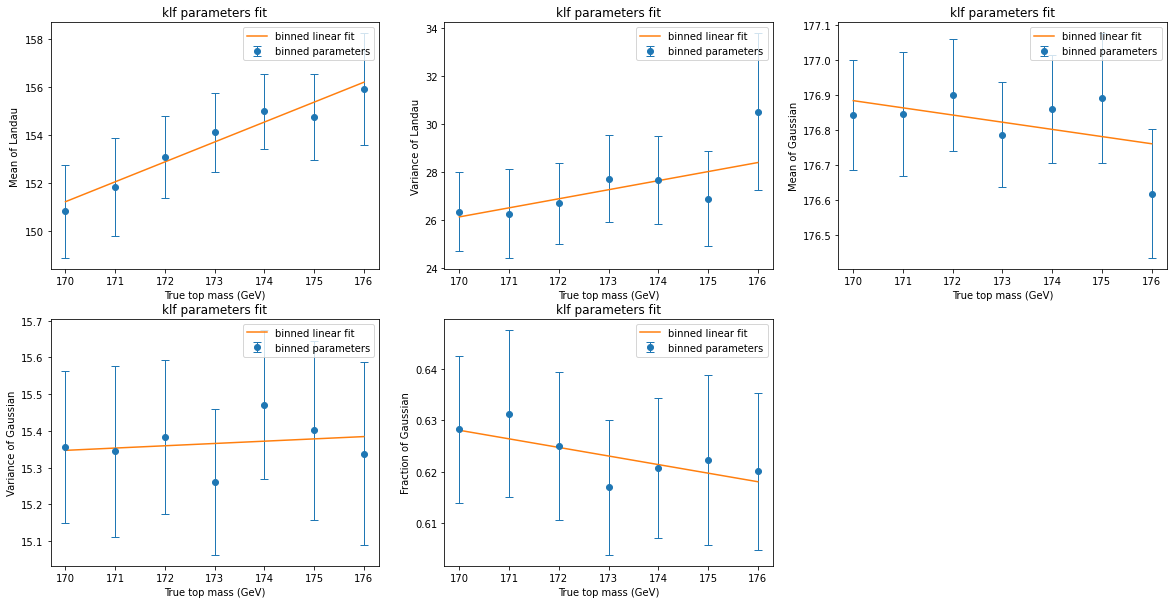

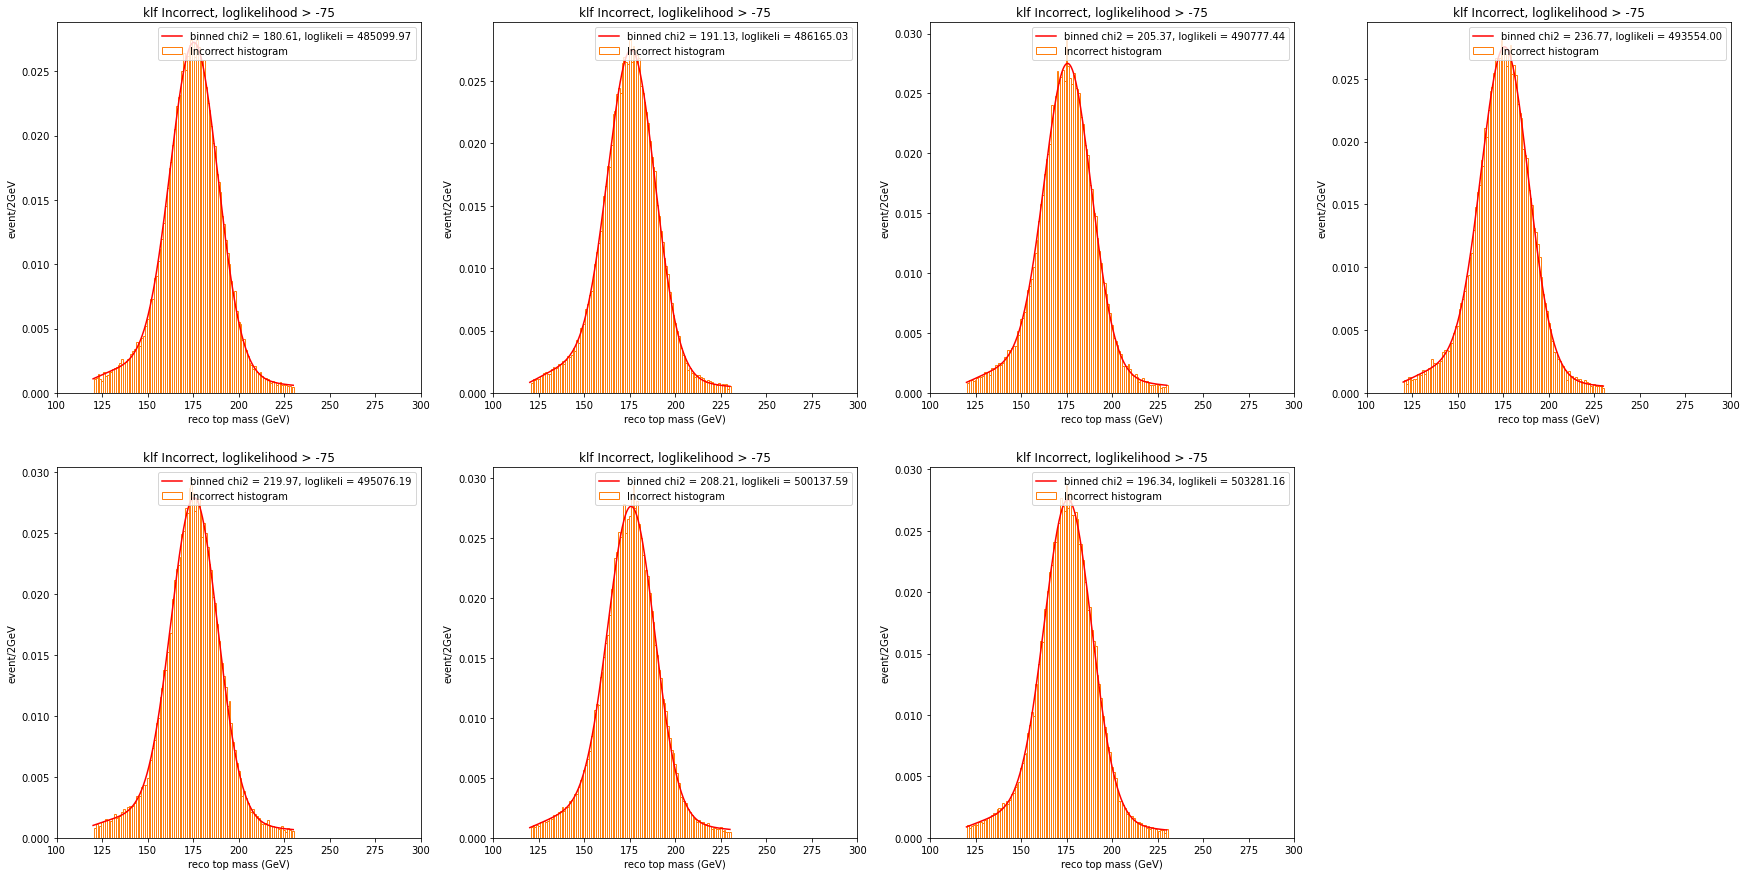

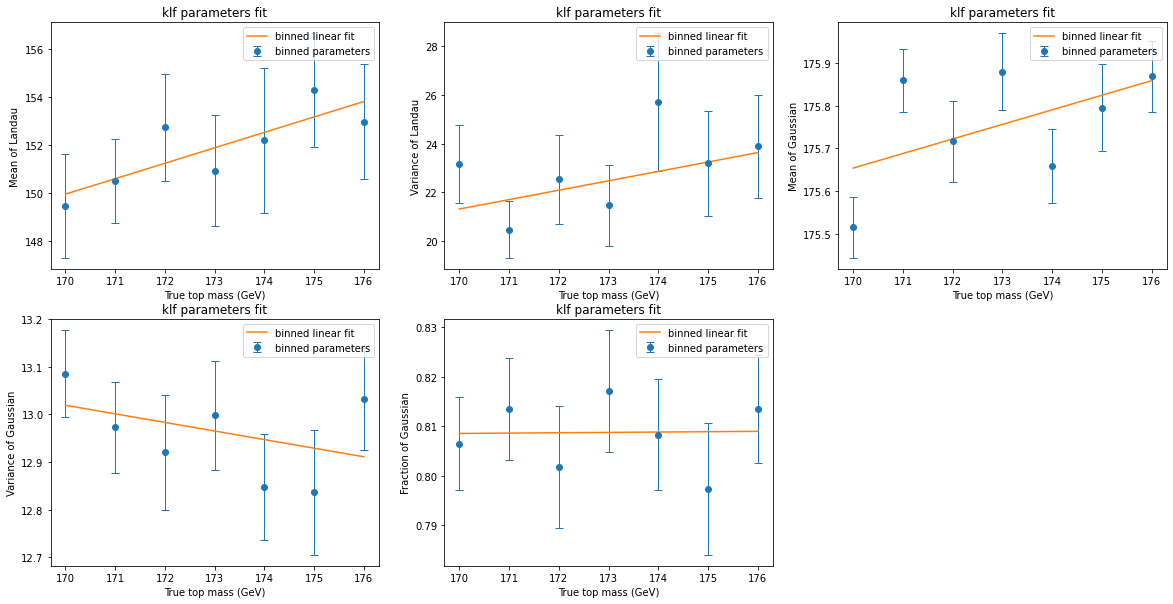

/tmp/ipykernel_45158/297714325.py:21: RuntimeWarning: divide by zero encountered in log
  loglikeli = -2*np.sum(np.log(two_gau_norm(fit_target, *popt)))


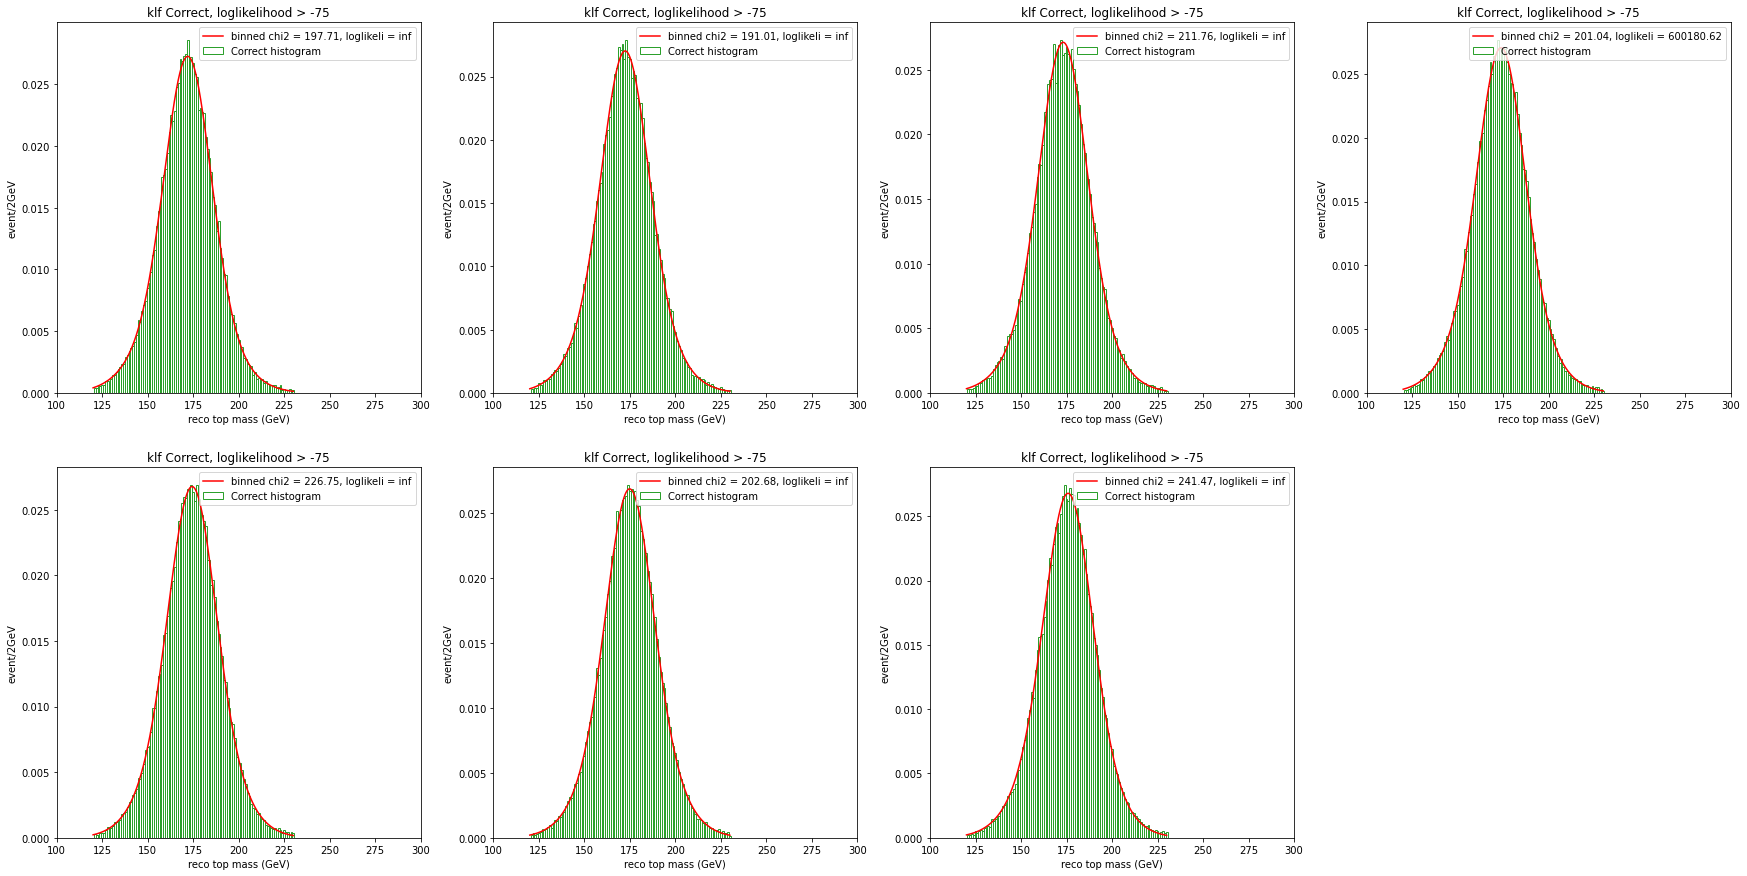

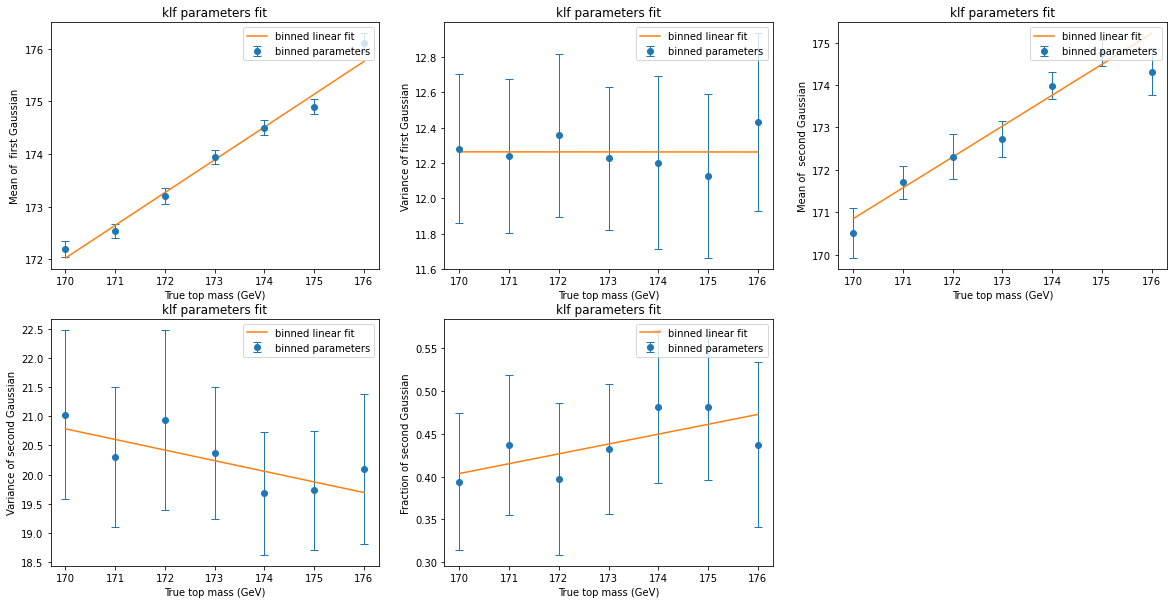

In [10]:
# Fit every class of klfitter
fita_klf_dic, fitb_klf_dic = {}, {}
fit_popt_dic = {}
fit_perr_dic = {}

for state_i in [0, 1, 2]:
    popt_klf_arr = []
    perr_klf_arr = []
    popt_klf_unbinned_arr = []

    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == state_i, loglikeli_klf_dic[m]>loglikeli_cut))]
        hist, bin_edges = np.histogram(fit_target, bins=bins, density=True)
        # 2Gaussian for correct
        if state_i == 2:
            popt, pcov = optimize.curve_fit(two_gau_norm, bin_edges[:-1]+1, hist, p0=(180, 10, 170, 25, 0.9), bounds=((160, 5, 160, 15, 0), (200, 15, 200, 35, 1)))
            y_dense = two_gau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, two_gau_norm(bins[:-1]+bins_w/2, *popt))
            loglikeli = -2*np.sum(np.log(two_gau_norm(fit_target, *popt)))

        # Landau + Gaussian for incorrect and unmatch
        else:
            popt, pcov = optimize.curve_fit(langau_norm, bin_edges[:-1]+1, hist, p0=(150, 20, 160, 20, 0.9), bounds=((140, 10, 140, 10, 0), (200, 50, 250, 30, 1)))
            y_dense = langau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, langau_norm(bins[:-1]+bins_w/2, *popt))
            loglikeli = -2*np.sum(np.log(langau_norm(fit_target, *popt)))

        popt_klf_arr.append(popt)
        perr_klf_arr.append(np.sqrt(np.diag(pcov)))
        plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_dense, c='r', label='binned chi2 = {:.2f}, loglikeli = {:.2f}'.format(chi2, loglikeli))
        plt.xlim(100, 300)
        plt.title('klf {}, loglikelihood > {}'.format(state_labels[state_i], loglikeli_cut))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/2GeV')
        plt.legend(loc='upper right')
    plt.savefig('./plots_topmass/klf_pdf_fit_{}.png'.format(state_labels[state_i]))
    plt.show()

    popt_klf_arr = np.transpose(np.array(popt_klf_arr))
    fit_popt_dic[state_i] = popt_klf_arr
    perr_klf_arr = np.transpose(np.array(perr_klf_arr))
    popt_klf_unbinned_arr = np.transpose(popt_klf_unbinned_arr)
    fita_klf_arr, fitb_klf_arr = [], []

    plt.figure(figsize=(20, 10))
    for i, arr in enumerate(popt_klf_arr):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, mass, arr, sigma=perr_klf_arr[i], method="lm")
        perr = np.sqrt(np.diag(pcov))
        plt.errorbar(mass, arr, yerr = perr_klf_arr[i], fmt='o', elinewidth=bins_w, capsize=4, label='binned parameters')
        y = linear(top_mass_dense, popt[0], popt[1])
        plt.plot(top_mass_dense, y, label='binned linear fit')
        plt.xlabel('True top mass (GeV)')
        if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
        else: plt.ylabel(langau_fit_labels[i])
        plt.title('klf parameters fit')
        fita_klf_arr.append(popt[0])
        fitb_klf_arr.append(popt[1])
        plt.legend(loc='upper right')
    plt.savefig('./plots_topmass/klf_param_fit_{}.png'.format(state_labels[state_i]))
    plt.show()
    fita_klf_dic[state_i] = fita_klf_arr
    fitb_klf_dic[state_i] = fitb_klf_arr

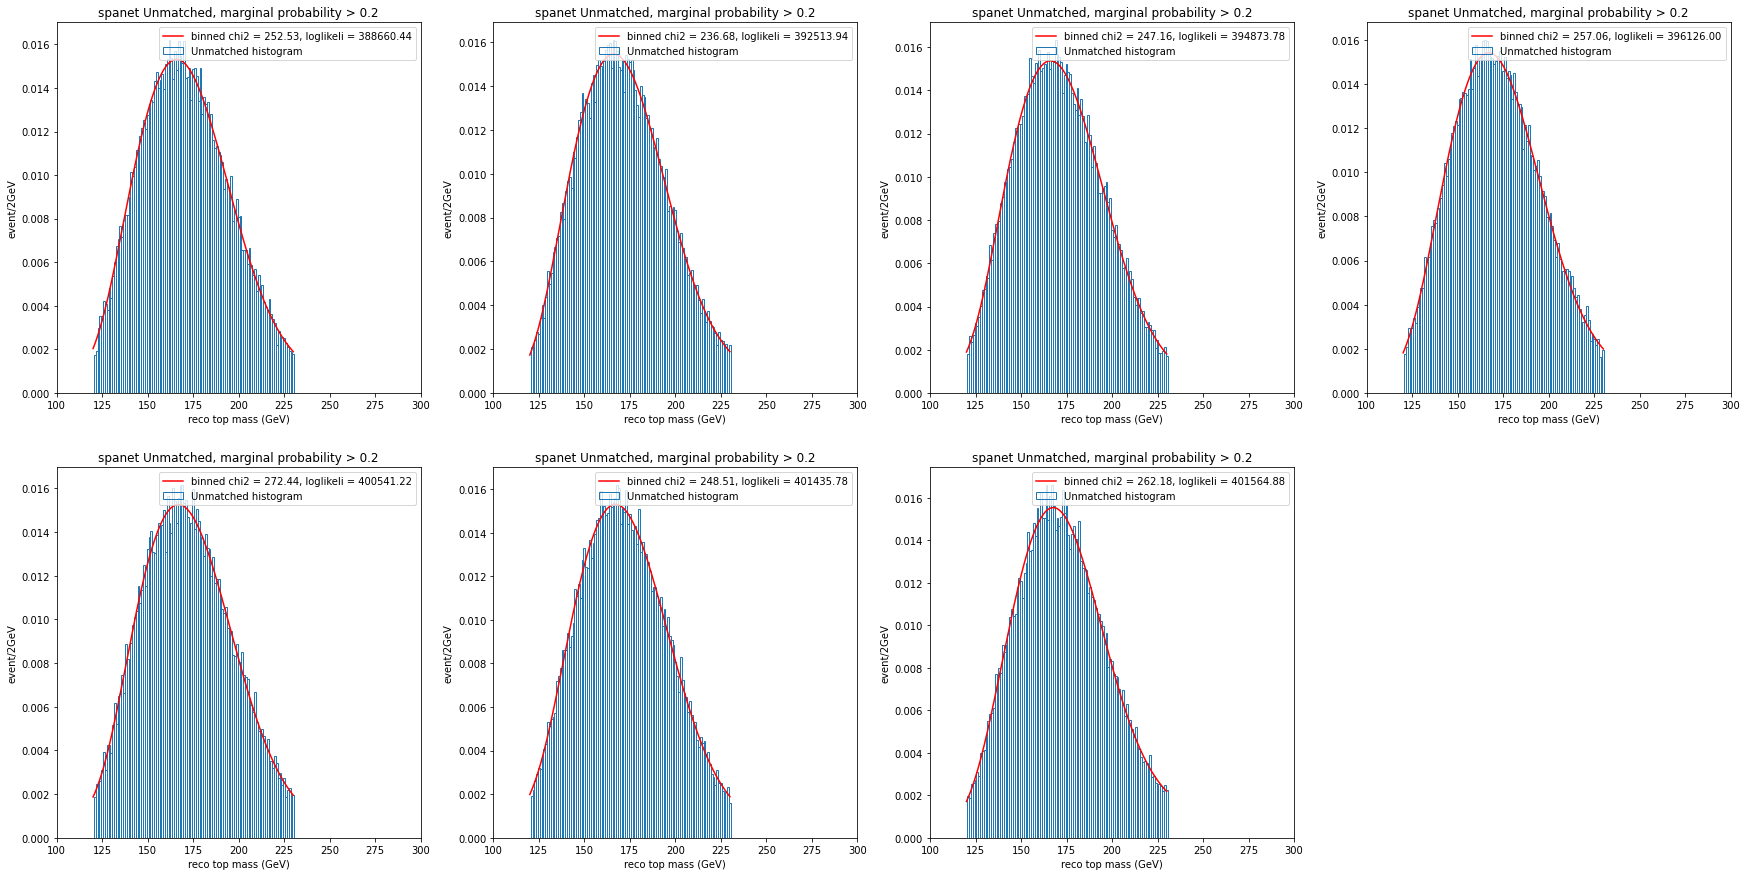

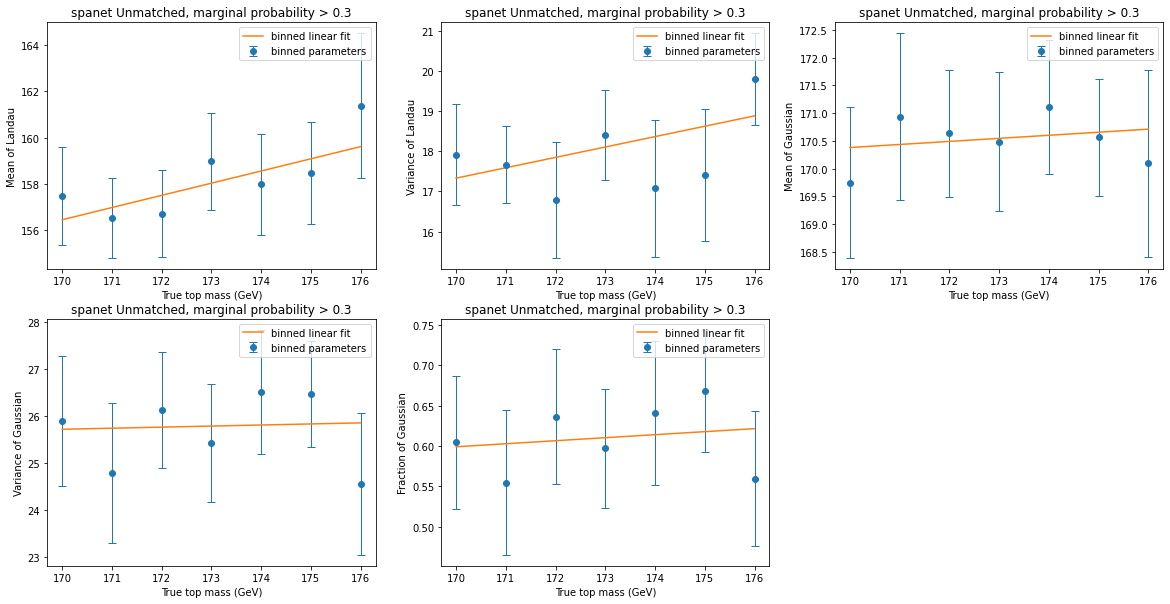

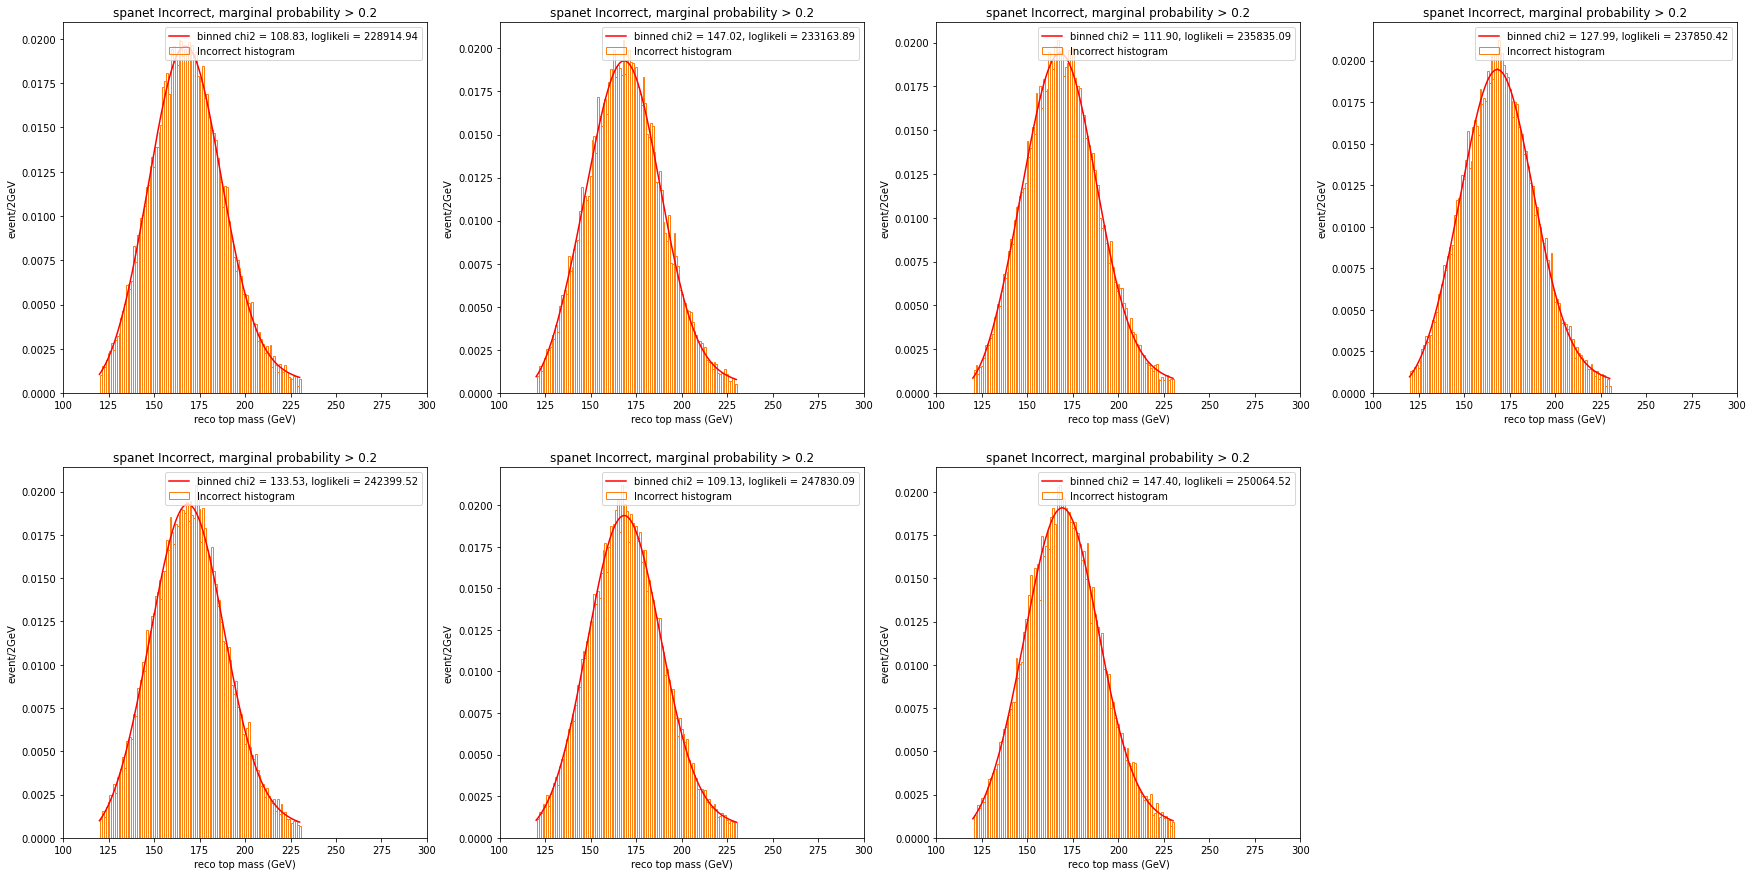

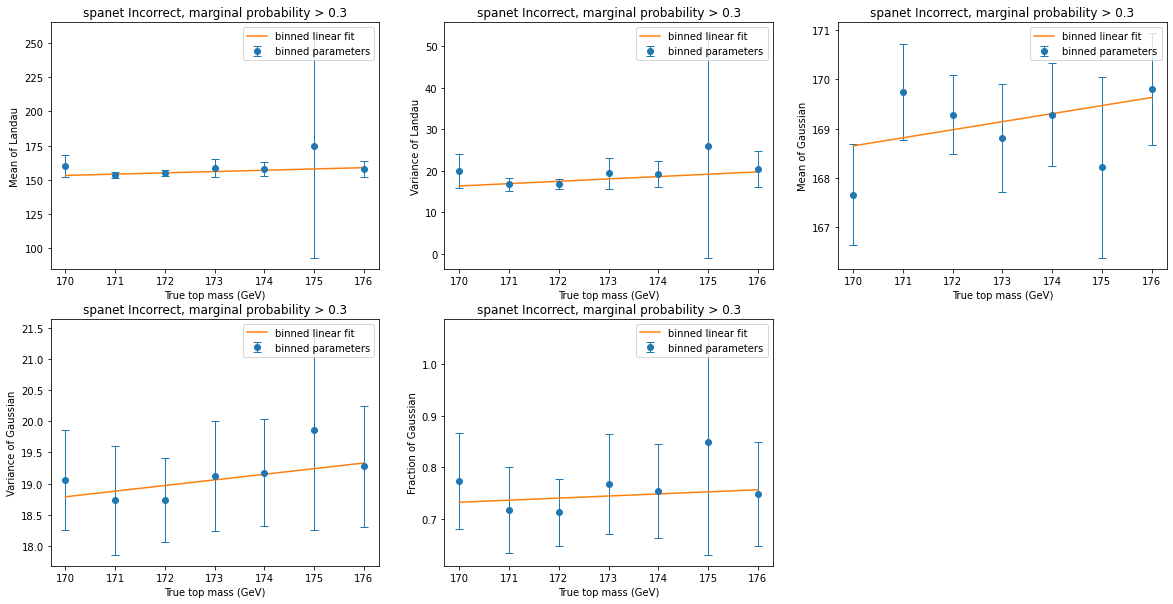

/tmp/ipykernel_45158/3914651491.py:20: RuntimeWarning: divide by zero encountered in log
  loglikeli = -2*np.sum(np.log(two_gau_norm(fit_target, *popt)))


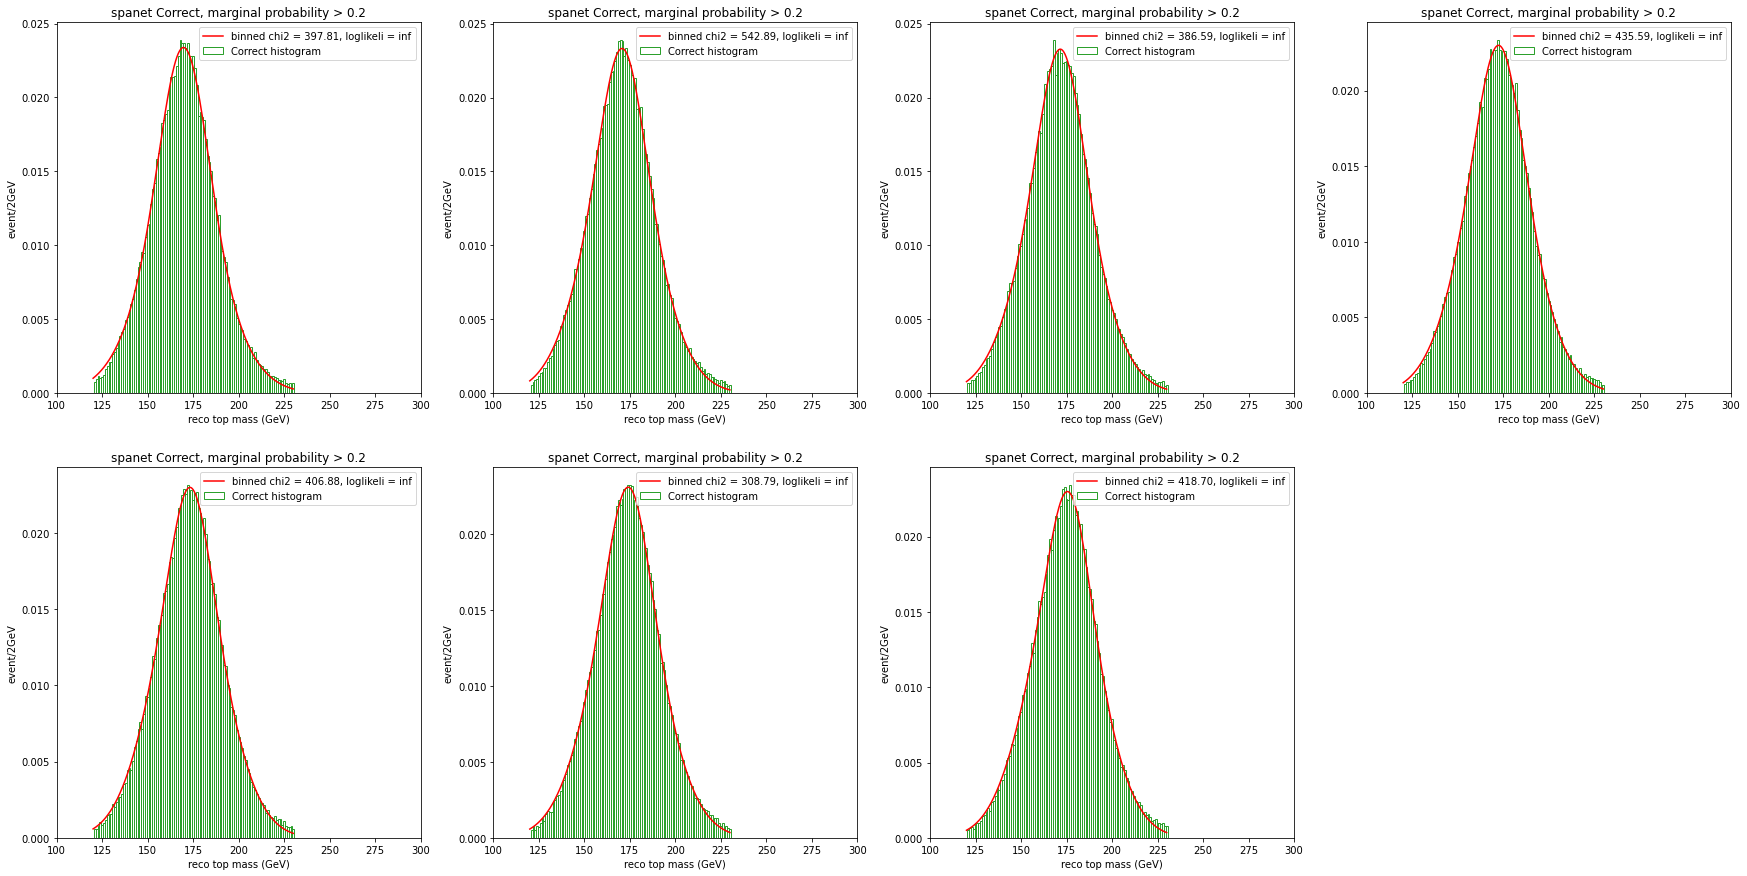

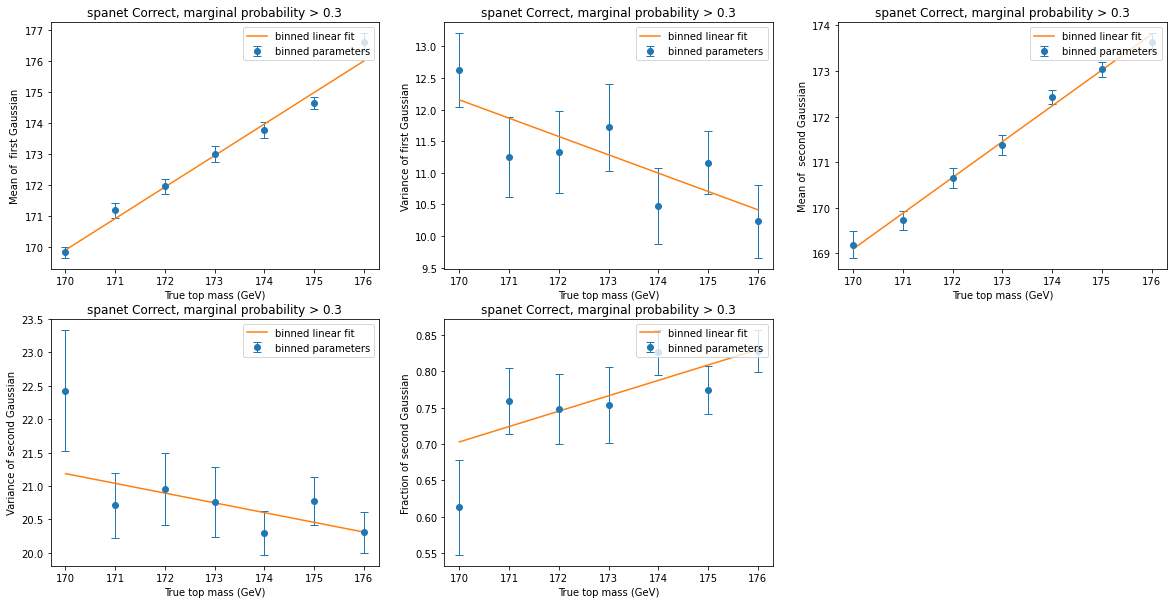

In [11]:
# Fit every class of spanet
fita_spanet_dic, fitb_spanet_dic = {}, {}
fit_popt_dic = {}
fit_perr_dic = {}

for state_i in [0, 1, 2]:
    popt_spanet_arr = []
    perr_spanet_arr = []
    
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == state_i, marginal_spanet_dic[m]>marginal_prob_cut))]
        hist, bin_edges = np.histogram(fit_target, bins=bins, density=True)
        # 2Gaussian for correct
        if state_i == 2:
            popt, pcov = optimize.curve_fit(two_gau_norm, bin_edges[:-1]+1, hist, p0=(180, 10, 170, 25, 0.9), bounds=((160, 5, 160, 15, 0), (200, 15, 200, 35, 1)))
            y_dense = two_gau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, two_gau_norm(bins[:-1]+bins_w/2, *popt))
            loglikeli = -2*np.sum(np.log(two_gau_norm(fit_target, *popt)))

        # Landau + Gaussian for incorrect and unmatch
        else:
            popt, pcov = optimize.curve_fit(langau_norm, bin_edges[:-1]+1, hist, p0=(150, 20, 160, 20, 0.9), bounds=((140, 10, 140, 10, 0), (200, 50, 250, 30, 1)))
            y_dense = langau_norm(bins_dense, *popt)
            chi2 = chi2_pdf(fit_target, langau_norm(bins[:-1]+bins_w/2, *popt))
            loglikeli = -2*np.sum(np.log(langau_norm(fit_target, *popt)))

        popt_spanet_arr.append(popt)
        perr_spanet_arr.append(np.sqrt(np.diag(pcov)))
        plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_dense, c='r', label='binned chi2 = {:.2f}, loglikeli = {:.2f}'.format(chi2, loglikeli))
        plt.xlim(100, 300)
        plt.title('spanet {}, marginal probability > {}'.format(state_labels[state_i], marginal_prob_cut))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/2GeV')
        plt.legend(loc = 'upper right')
    plt.savefig('./plots_topmass/spanet_pdf_fit_{}.png'.format(state_labels[state_i]))
    plt.show()

    popt_spanet_arr = np.transpose(np.array(popt_spanet_arr))
    fit_popt_dic[state_i] = popt_spanet_arr
    perr_spanet_arr = np.transpose(np.array(perr_spanet_arr))
    fita_spanet_arr, fitb_spanet_arr = [], []

    plt.figure(figsize=(20, 10))
    for i, arr in enumerate(popt_spanet_arr):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, mass, arr, sigma=perr_spanet_arr[i], method="lm")
        perr = np.sqrt(np.diag(pcov))
        plt.errorbar(mass, arr, yerr = perr_spanet_arr[i], fmt='o', elinewidth=bins_w, capsize=4, label='binned parameters')
        y = linear(top_mass_dense, popt[0], popt[1])
        plt.plot(top_mass_dense, y, label='binned linear fit')
        plt.xlabel('True top mass (GeV)')
        if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
        else: plt.ylabel(langau_fit_labels[i])
        plt.title('spanet {}, marginal probability > 0.3'.format(state_labels[state_i]))
        fita_spanet_arr.append(popt[0])
        fitb_spanet_arr.append(popt[1])
        plt.legend(loc='upper right')
    plt.savefig('./plots_topmass/spanet_param_fit_{}.png'.format(state_labels[state_i]))
    plt.show()
    fita_spanet_dic[state_i] = fita_spanet_arr
    fitb_spanet_dic[state_i] = fitb_spanet_arr

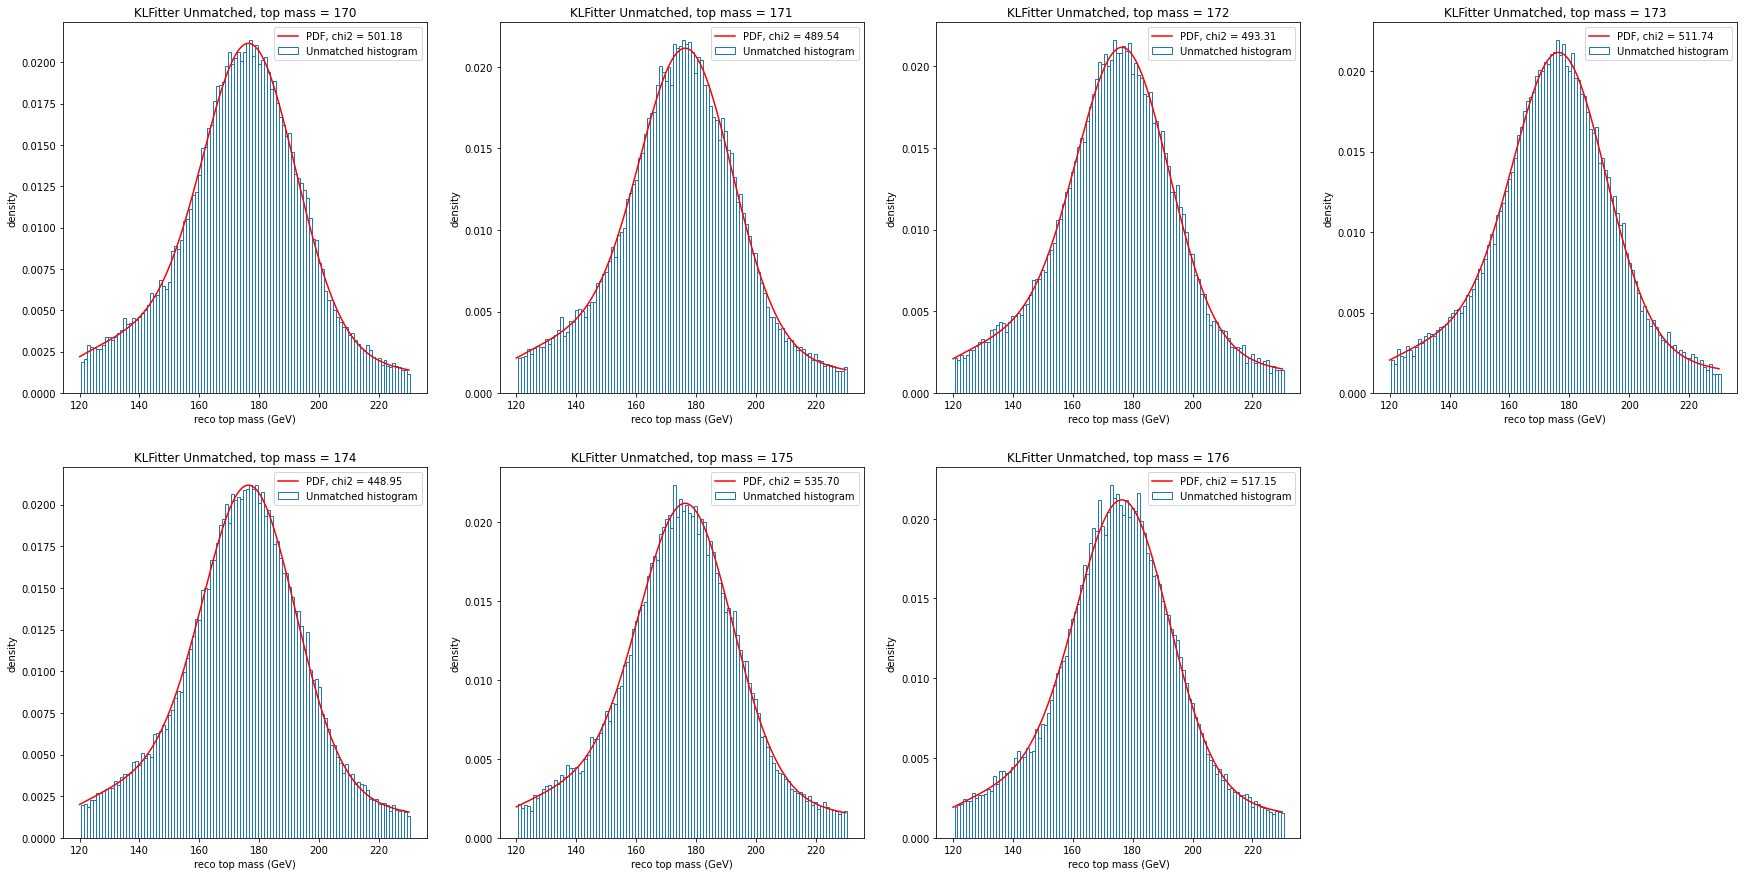

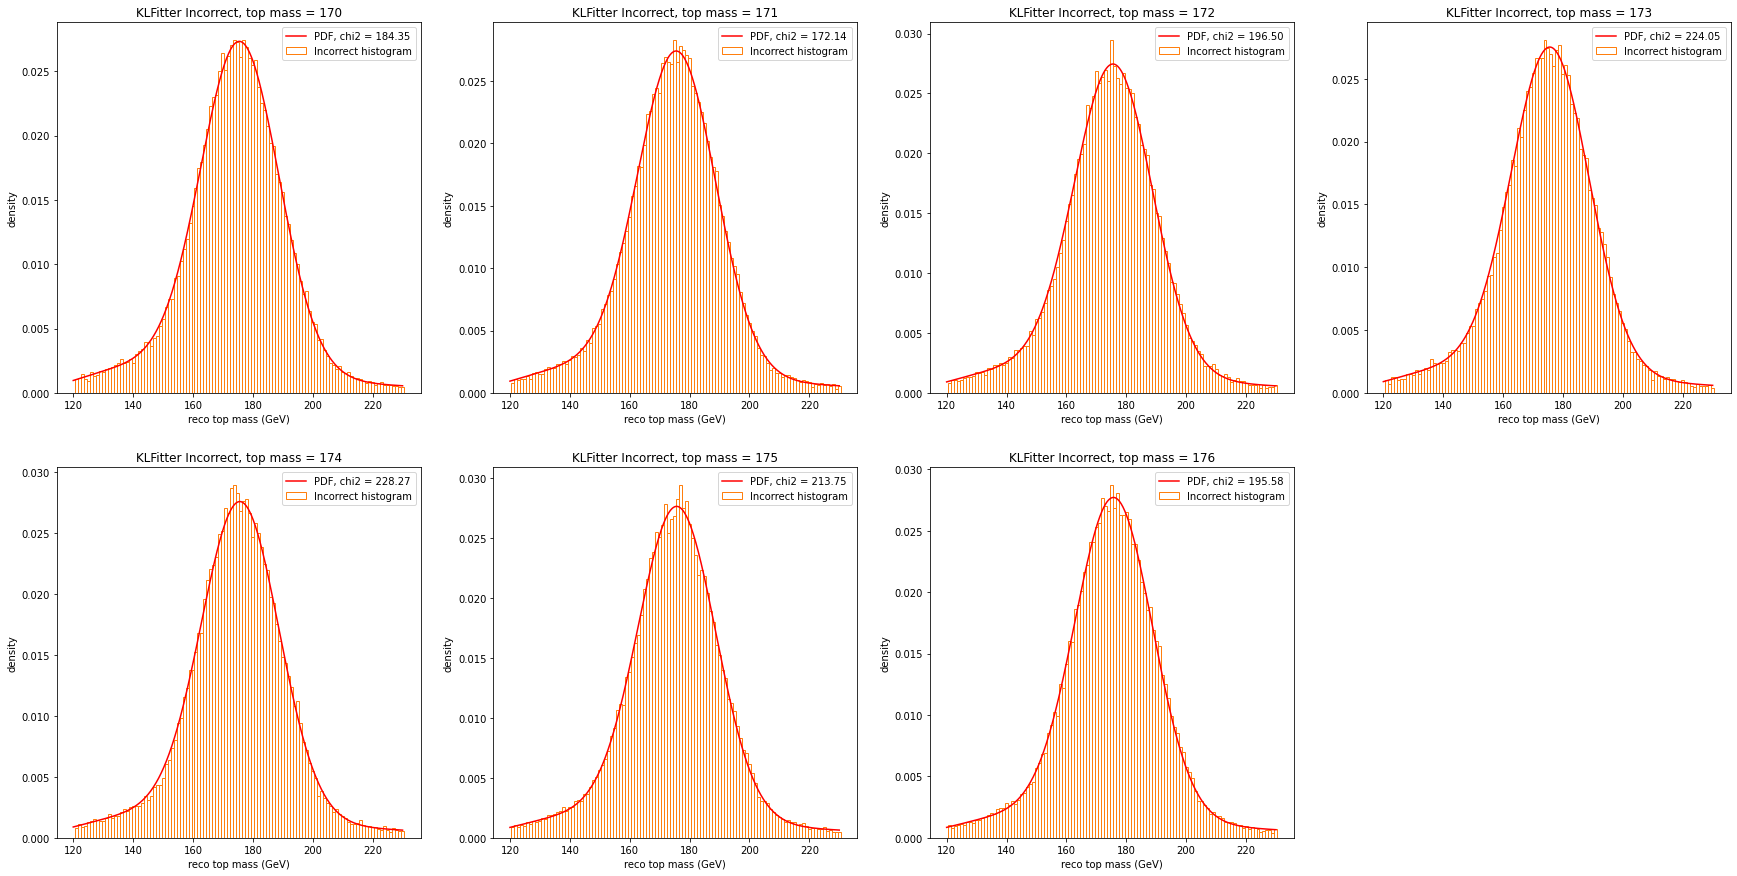

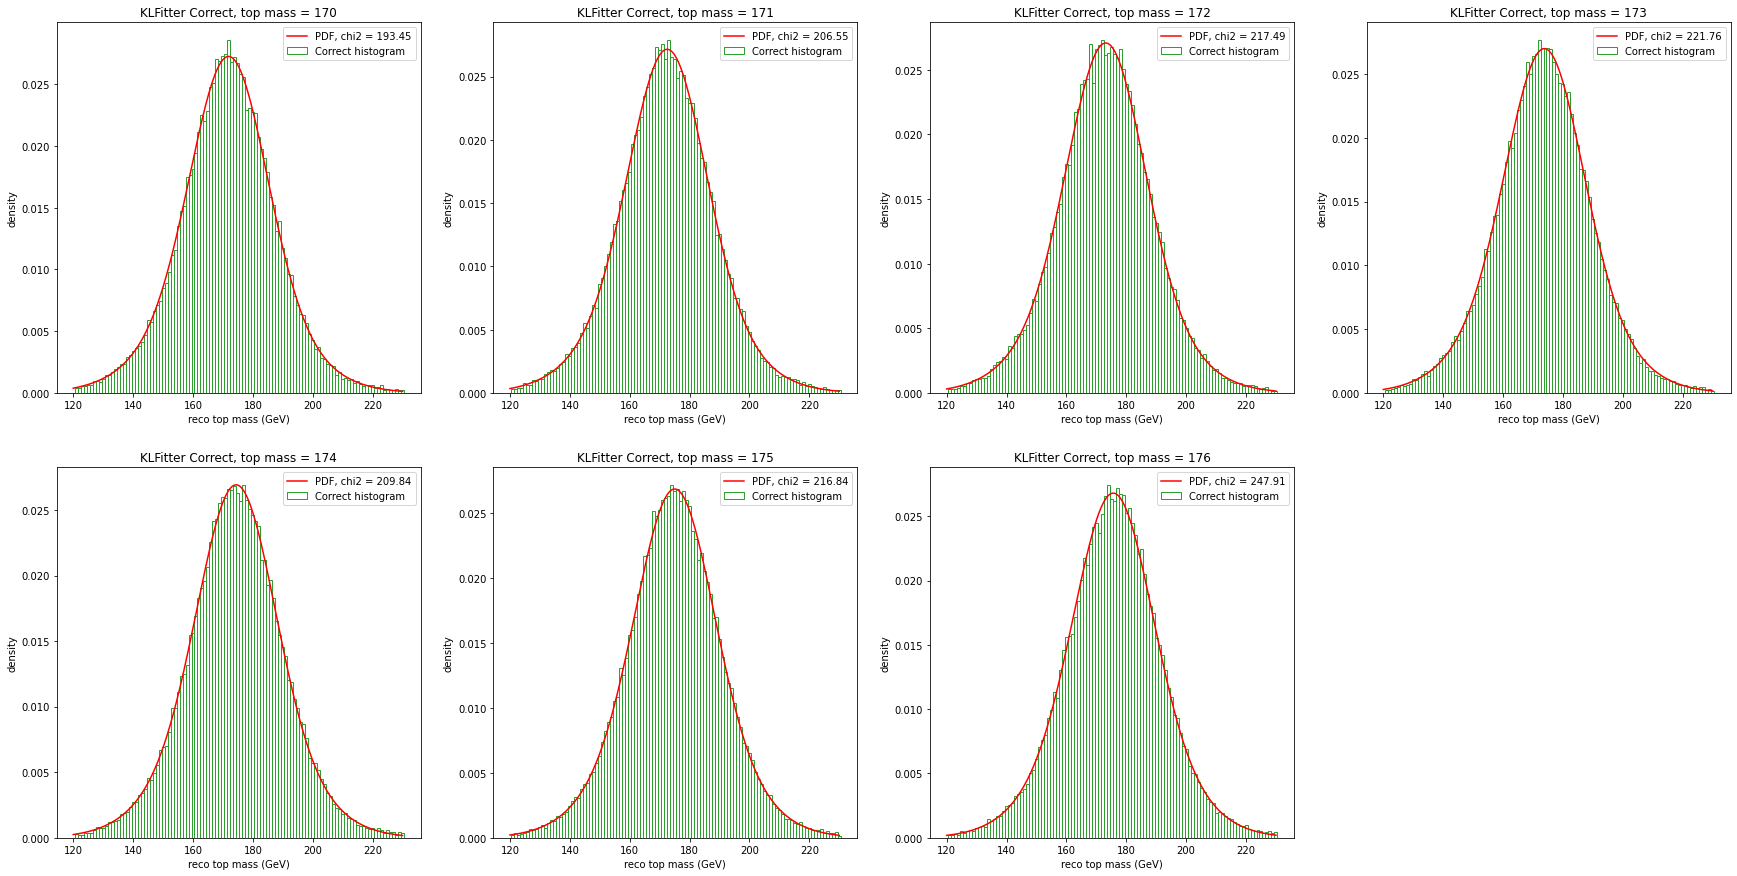

In [12]:
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == state_i, loglikeli_klf_dic[m]>loglikeli_cut))]
        hist, bin_edges = np.histogram(target, bins=bins, density=True)
        popt = np.array(fita_klf_dic[state_i])*m+fitb_klf_dic[state_i]
        if state_i  == 2:
            y_template_dense_norm = two_gau_norm(bins_dense, *popt)
            chi2_pdf_value = chi2_pdf(target, two_gau_norm(bins[:-1]+bins_w/2, *popt))
        else:
            y_template_dense_norm = langau_norm(bins_dense, *popt)
            chi2_pdf_value = chi2_pdf(target, langau_norm(bins[:-1]+bins_w/2, *popt))

        plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('KLFitter {}, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.show()

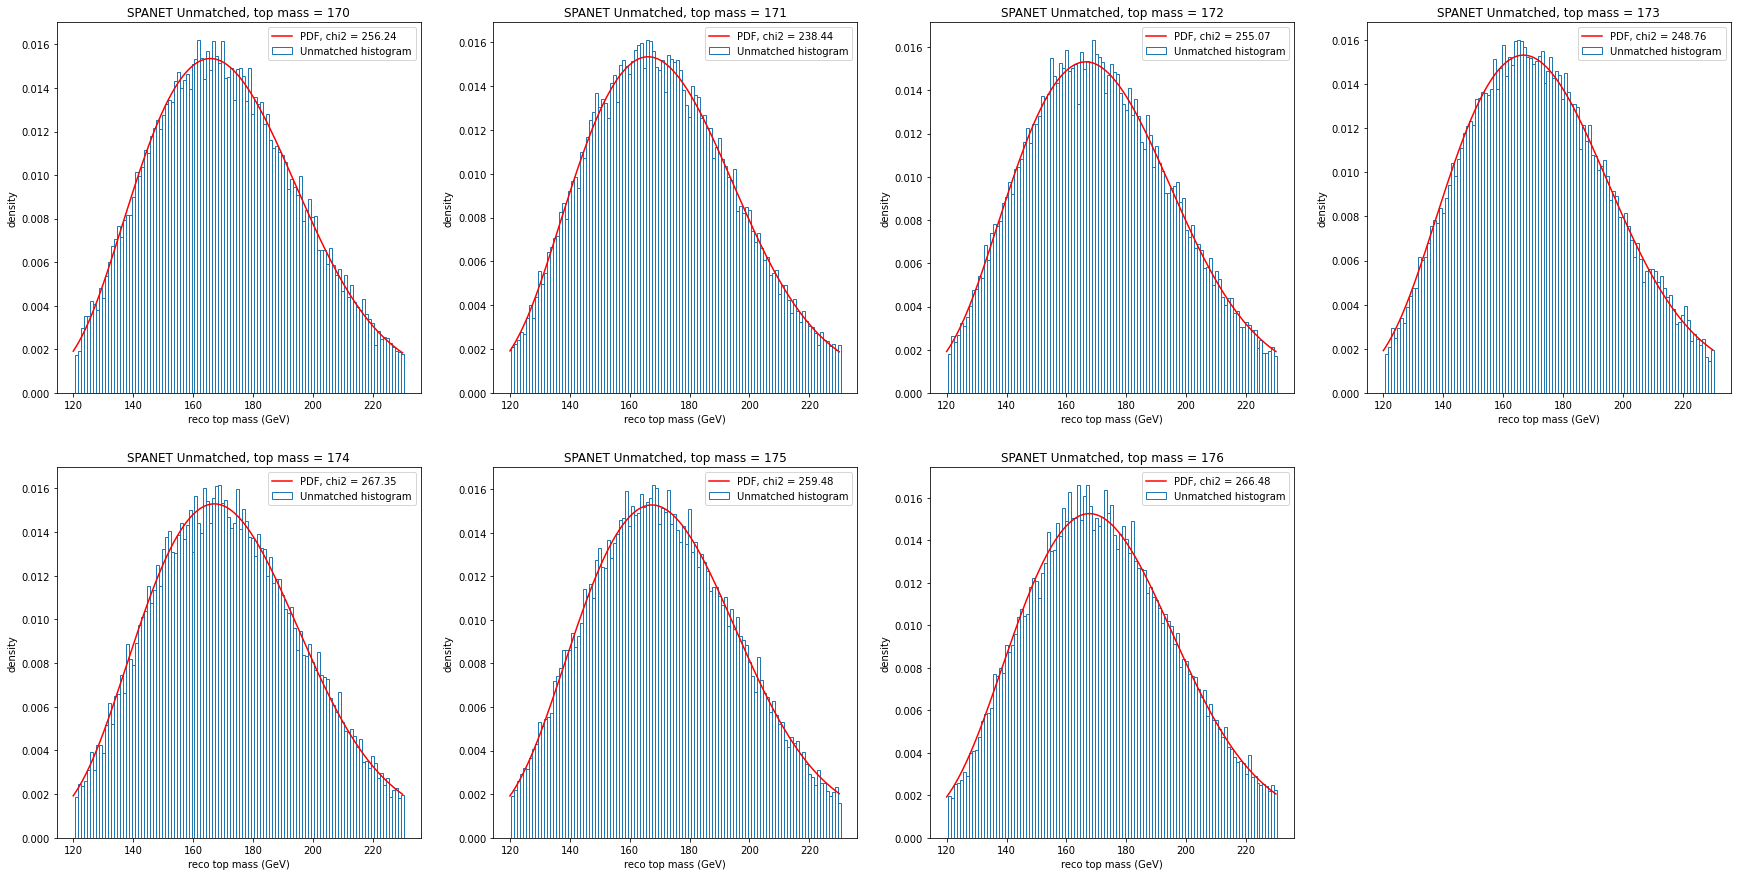

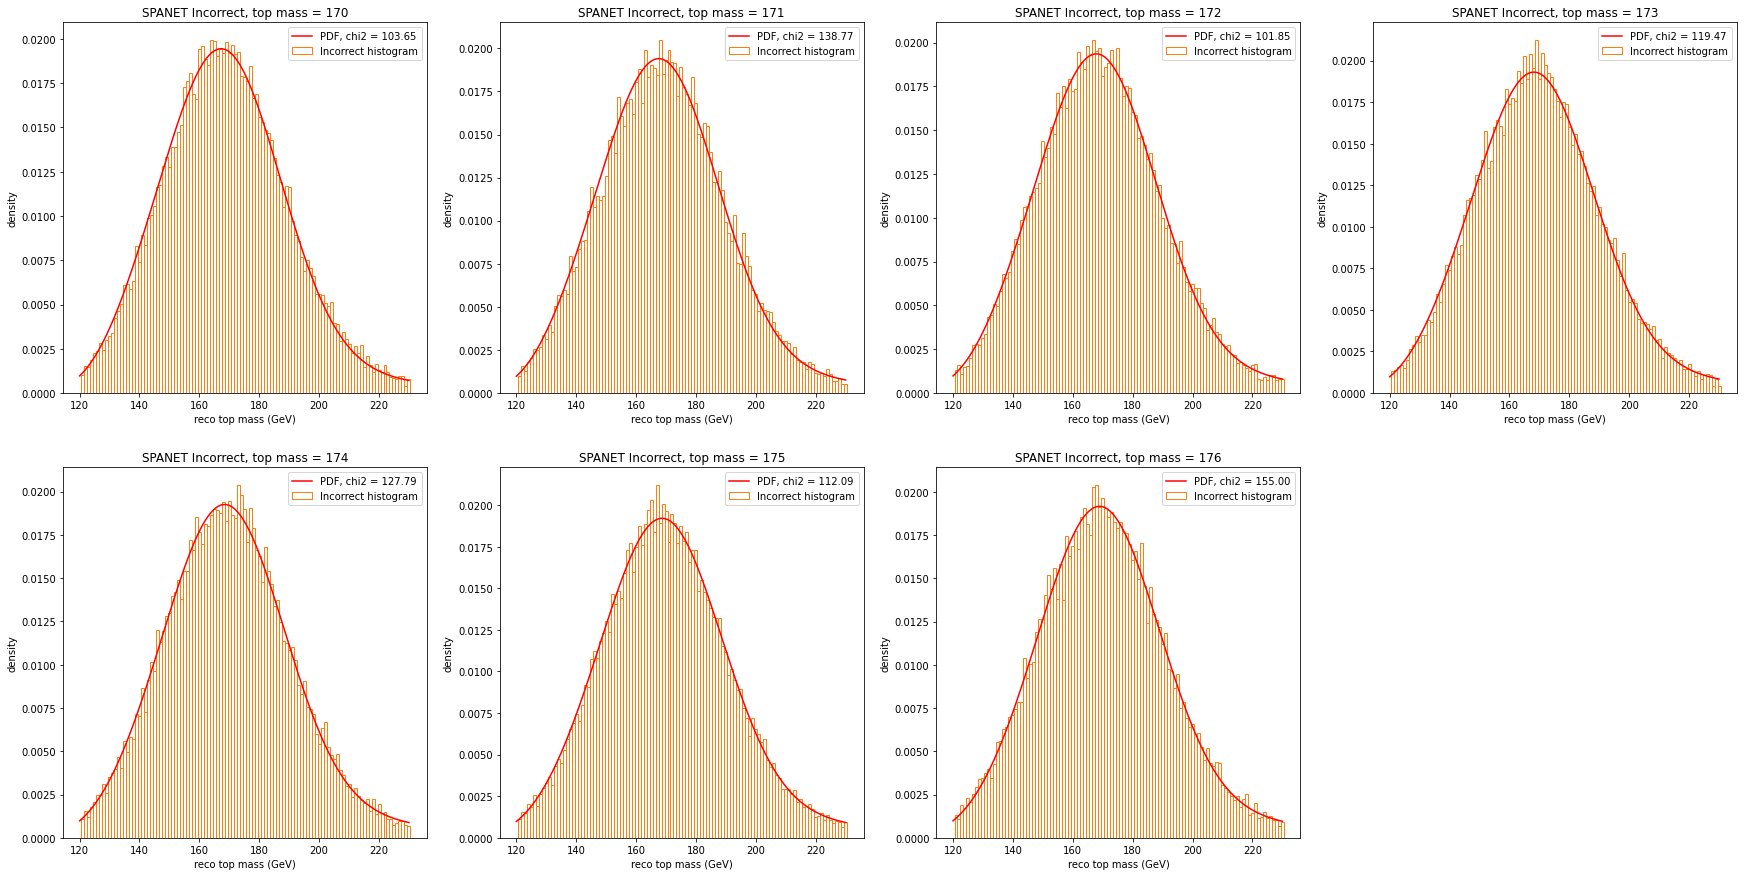

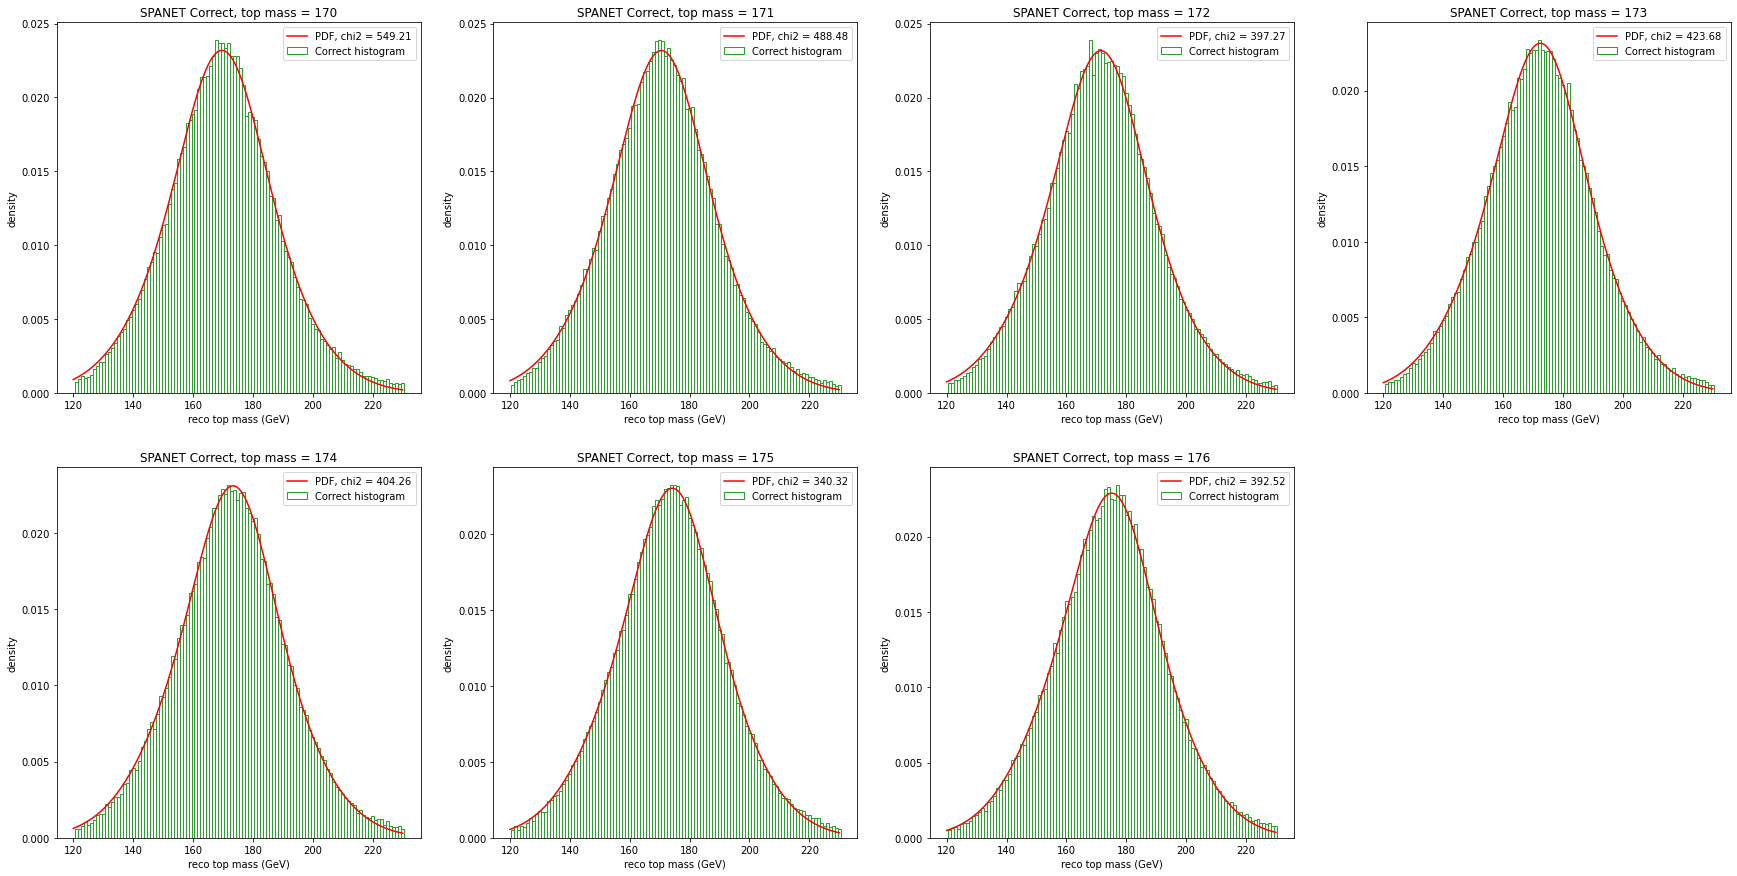

In [13]:
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == state_i, marginal_spanet_dic[m]>marginal_prob_cut))]
        hist, bin_edges = np.histogram(target, bins=bins, density=True)
        popt = np.array(fita_spanet_dic[state_i])*m+fitb_spanet_dic[state_i]
        if state_i  == 2:
            y_template_dense_norm = two_gau_norm(bins_dense, *popt)
            chi2_pdf_value = chi2_pdf(target, two_gau_norm(bins[:-1]+bins_w/2, *popt))
        else:
            y_template_dense_norm = langau_norm(bins_dense, *popt)
            chi2_pdf_value = chi2_pdf(target, langau_norm(bins[:-1]+bins_w/2, *popt))

        plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('SPANET {}, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.show()

In [14]:
def combine_klf_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in [0, 1, 2]:
        popt = np.array(fita_klf_dic[state_i])*m + fitb_klf_dic[state_i]
        if state_i == 2: hist += two_gau_norm(x, *popt)*ratio_klf[state_i]
        else: hist += langau_norm(x, *popt)*ratio_klf[state_i]
    return hist

def combine_spanet_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in [0, 1, 2]:
        popt = np.array(fita_spanet_dic[state_i])*m + fitb_spanet_dic[state_i]
        if state_i == 2: hist += two_gau_norm(x, *popt)*ratio_spanet[state_i]
        else: hist += langau_norm(x, *popt)*ratio_spanet[state_i]
    return hist

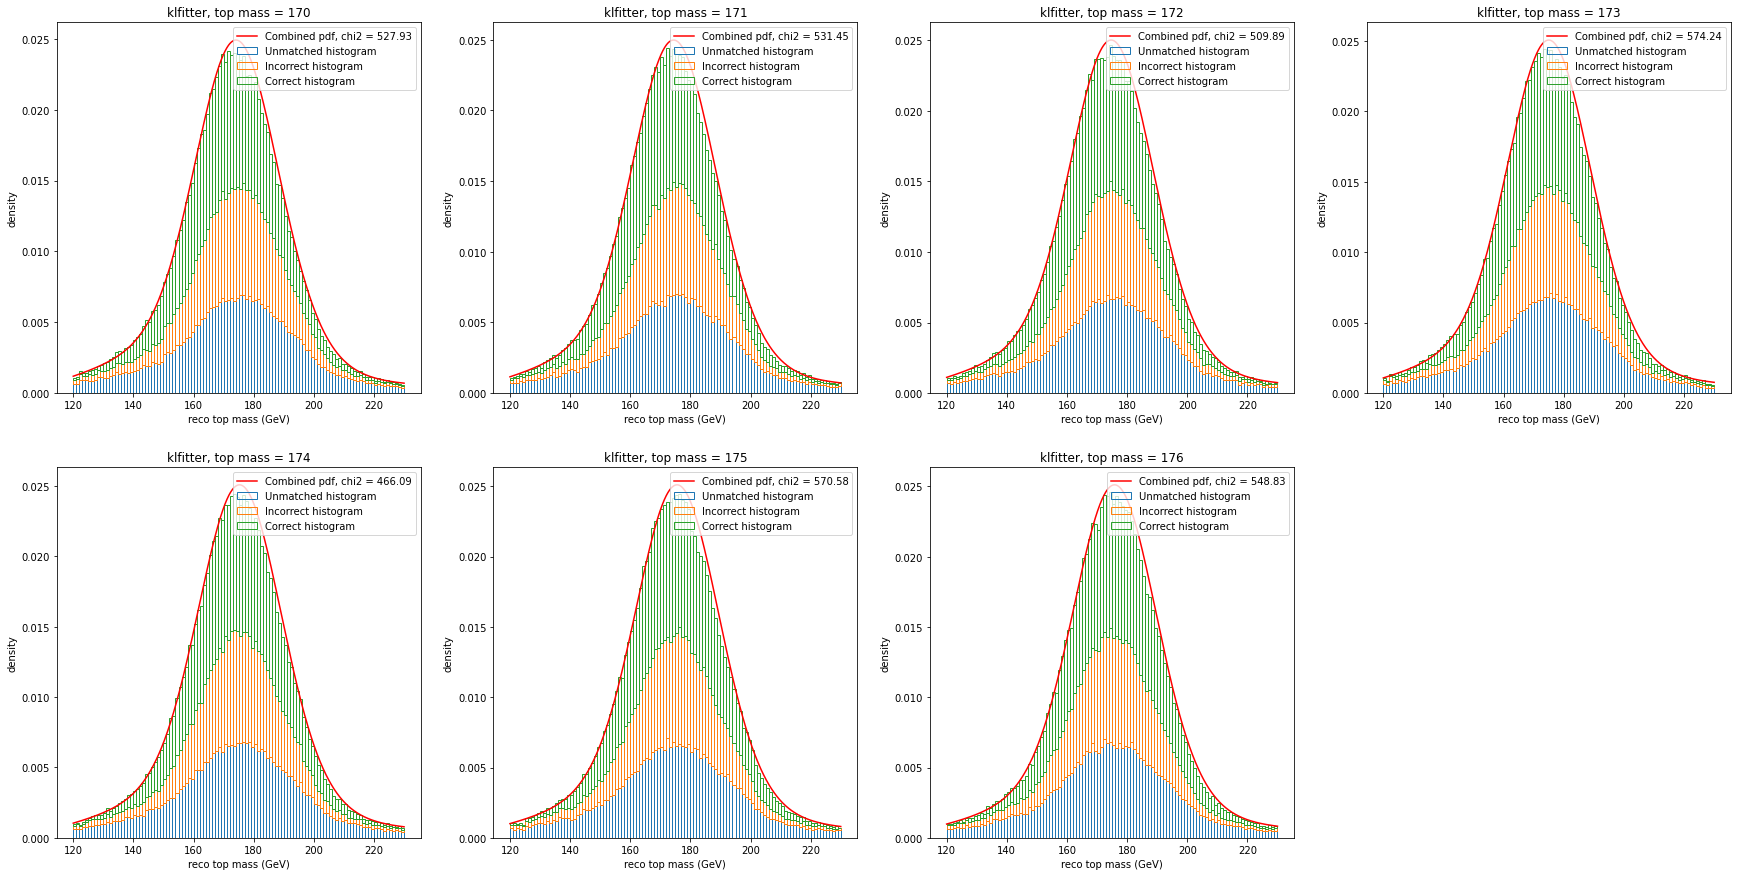

In [15]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))]
    klf_pdf = combine_klf_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_klf_pdf_func(bins[:-1]+bins_w/2, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in [0, 1, 2]:
        hist, _ = np.histogram(reco_klf_dic[m][np.logical_and.reduce((state_klf_dic[m] == state_i, cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))], bins=bins)
        plt.bar(bins[:-1]+bins_w/2, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, klf_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('klfitter, top mass = {}'.format(m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.savefig('./plots_topmass/combined_klf_pdf_check.png')
plt.show()

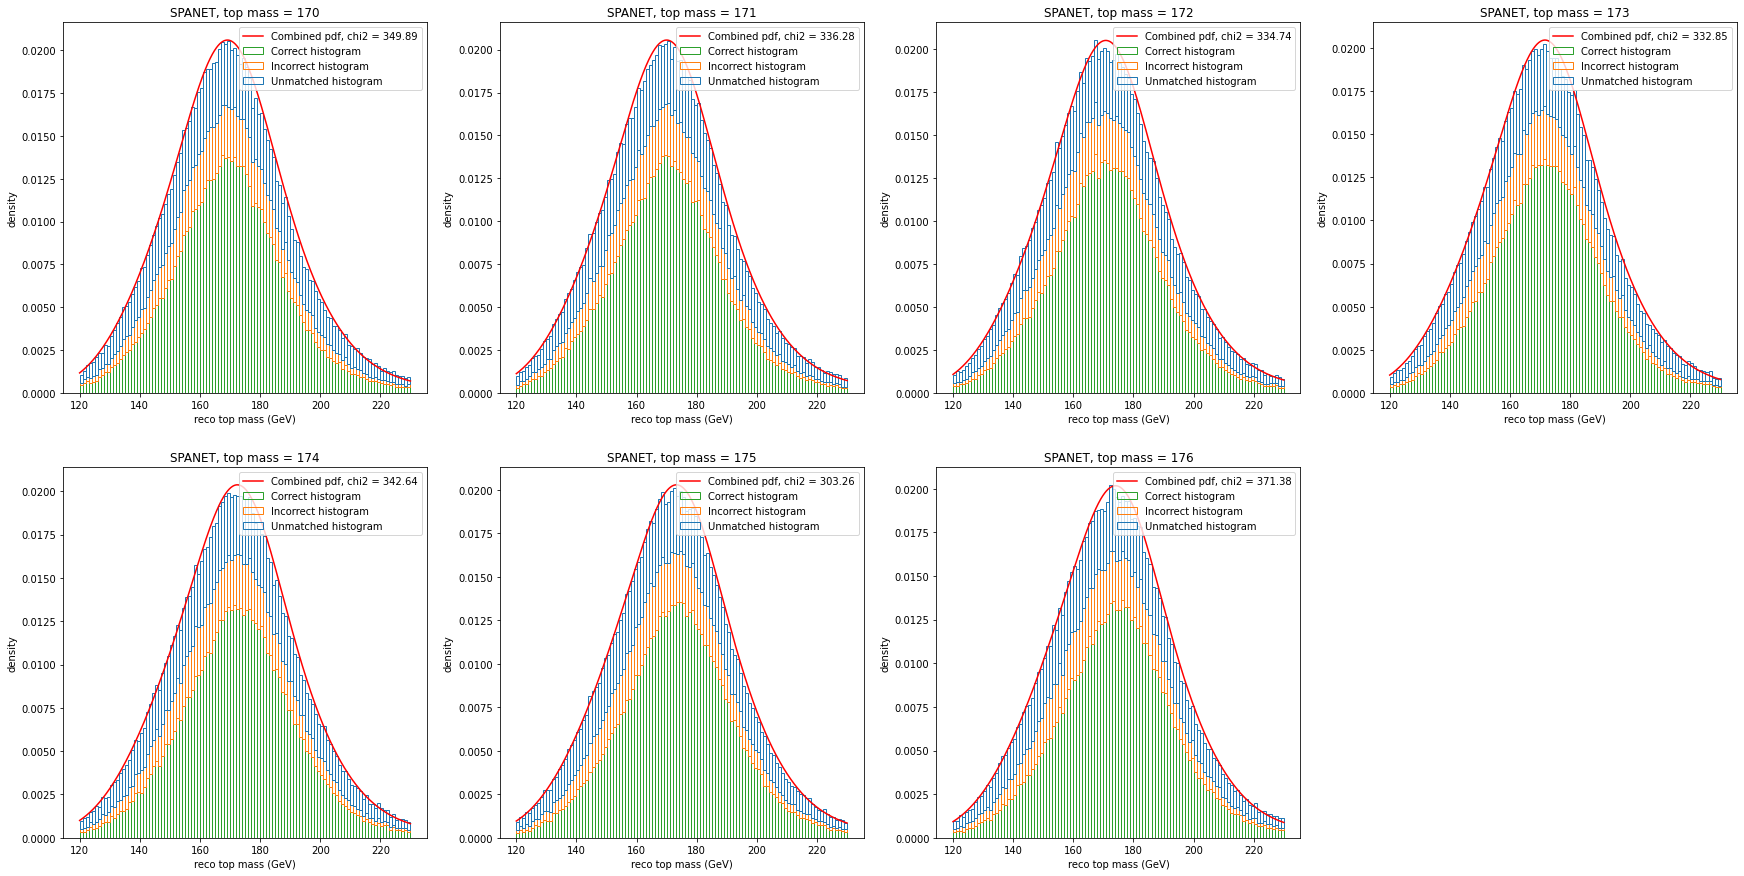

In [16]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut))]
    spanet_pdf = combine_spanet_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_spanet_pdf_func(bins[:-1]+bins_w/2, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in [2, 1, 0]:
        hist, _ = np.histogram(reco_spanet_dic[m][np.logical_and.reduce((state_spanet_dic[m] == state_i, cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut))], bins=bins)
        plt.bar(bins[:-1]+bins_w/2, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, spanet_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('SPANET, top mass = {}'.format(m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.savefig('./plots_topmass/combined_spanet_pdf_check.png')
plt.show()

In [26]:
#Sudo experiment for KLFitter
sudo_klf_mean_dic = defaultdict(list)
sudo_klf_variace_dic = defaultdict(list)

for m in mass:
    sudo_klf = np.random.choice(reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>loglikeli_cut))], size=(N, tot_event))
    n1 = np.array([np.histogram(sudo_klf[i], bins=bins)[0] for i in range(N)])
    n2 = [combine_klf_pdf_func(bins[:-1]+bins_w/2, m)*bins_w*tot_event for m in top_mass_chi2]
    chi2_klf_arr = [[np.sum((n1[i]-n2[j])**2/n2[j]) for j in range(len(top_mass_chi2))] for i in range(N)]
    loglikeli_klf_min = np.min(chi2_klf_arr, axis=1)
    sudo_klf_mean_dic[m] = top_mass_chi2[np.argmin(chi2_klf_arr, axis=1)]
    top_mass_min = top_mass_chi2[np.array([np.where(chi2_klf_arr[i] < loglikeli_klf_min[i]+1)[0][0] for i in range(N)])]
    top_mass_max = top_mass_chi2[np.array([np.where(chi2_klf_arr[i] < loglikeli_klf_min[i]+1)[0][-1] for i in range(N)])]
    sudo_klf_variace_dic[m] = (top_mass_max - top_mass_min)/2

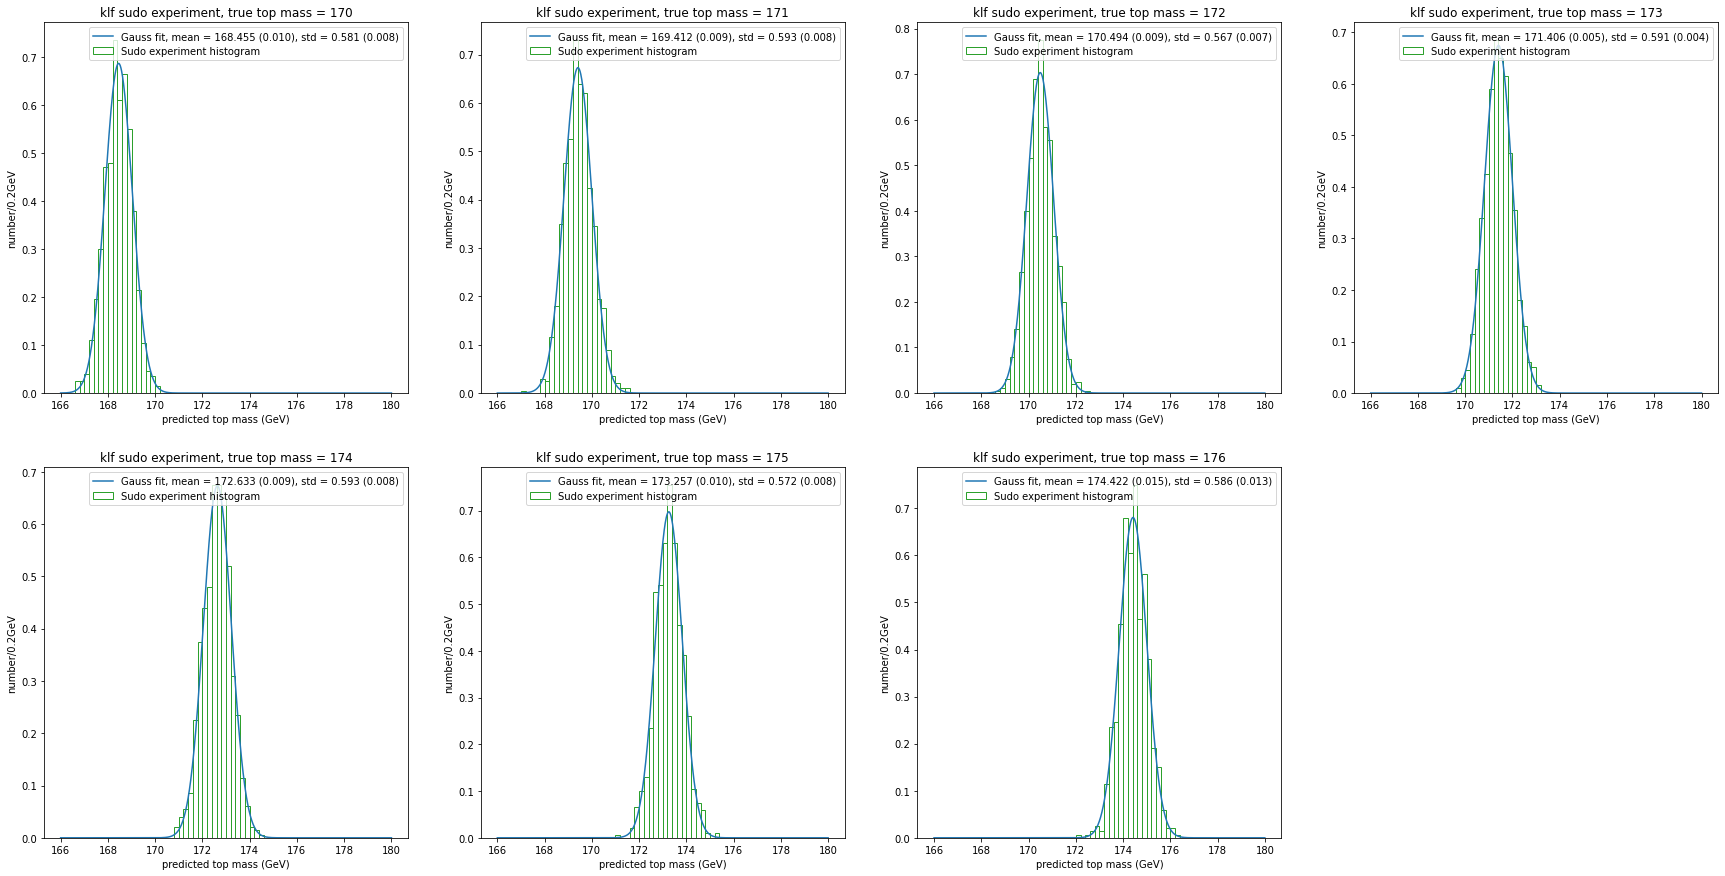

In [27]:
plt.figure(figsize=(30, 15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    hist, _ = np.histogram(sudo_klf_mean_dic[m], bins=sudo_bins, density=True)
    popt, pcov = optimize.curve_fit(gau_norm, sudo_bins[:-1]+0.1, hist, p0 = (170, 2))
    perr = np.sqrt(np.diag(pcov))
    plt.plot(sudo_bins_dense, gau_norm(sudo_bins_dense, *popt), label = 'Gauss fit, mean = {:.3f} ({:.3f}), std = {:.3f} ({:.3f})'.format(popt[0], perr[0], popt[1], perr[1]))
    plt.bar(sudo_bins[:-1]+0.1, hist, edgecolor=colors[2], width=0.2, color='None', label = 'Sudo experiment histogram')
    plt.title('klf sudo experiment, true top mass = {}'.format(m))
    plt.xlabel('predicted top mass (GeV)')
    plt.ylabel('number/0.2GeV')
    plt.legend(loc='upper right')
plt.savefig('./plots_topmass/klf_sudo_experiment.png')
plt.show()

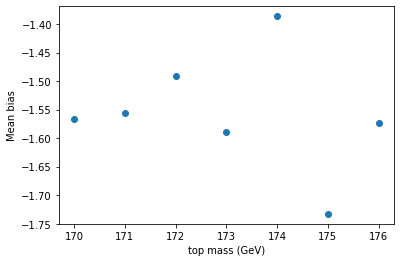

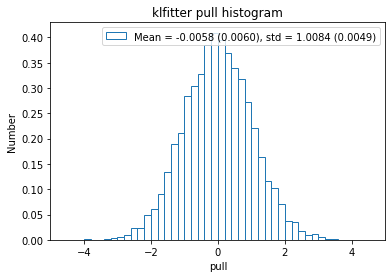

172.979985985986, (0.13213213213212782)


In [28]:
plt.scatter(mass, [np.mean(sudo_klf_mean_dic[m])-m for m in mass])
plt.xlabel('top mass (GeV)')
plt.ylabel('Mean bias')
plt.savefig('./plots_topmass/klf_bias.png')
plt.show()

klf_bias = np.mean([np.mean(sudo_klf_mean_dic[m])-m for m in mass])

pull_klf = []
for m in mass:
    pull_klf.extend((np.array(sudo_klf_mean_dic[m])-m-klf_bias)/np.array(sudo_klf_variace_dic[m]))
hist, bin_edges = np.histogram(pull_klf, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor=colors[state_i], width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
plt.title('klfitter pull histogram')
plt.xlim(-5, 5)
plt.xlabel('pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.savefig('./plots_topmass/klf_pull.png')
plt.show()
print('{}, ({})'.format(klf_top_mass - klf_bias, klf_top_mass_std))

In [44]:
# Sudo experiment for SPANET
sudo_spanet_mean_dic = defaultdict(list)
sudo_spanet_variace_dic = defaultdict(list)

for m in mass:
    sudo_spanet = np.random.choice(reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], marginal_spanet_dic[m]>marginal_prob_cut))], size=(N, tot_event))
    n1 = np.array([np.histogram(sudo_spanet[i], bins=bins)[0] for i in range(N)])
    n2 = [combine_spanet_pdf_func(bins[:-1]+bins_w/2, m)*bins_w*tot_event for m in top_mass_chi2]
    chi2_spanet_arr = [[np.sum((n1[i]-n2[j])**2/n2[j]) for j in range(len(top_mass_chi2))] for i in range(N)]
    loglikeli_spanet_min = np.min(chi2_spanet_arr, axis=1)
    sudo_spanet_mean_dic[m] = top_mass_chi2[np.argmin(chi2_spanet_arr, axis=1)]
    top_mass_min = top_mass_chi2[np.array([np.where(chi2_spanet_arr[i] < loglikeli_spanet_min[i]+1)[0][0] for i in range(N)])]
    top_mass_max = top_mass_chi2[np.array([np.where(chi2_spanet_arr[i] < loglikeli_spanet_min[i]+1)[0][-1] for i in range(N)])]
    sudo_spanet_variace_dic[m] = (top_mass_max - top_mass_min)/2

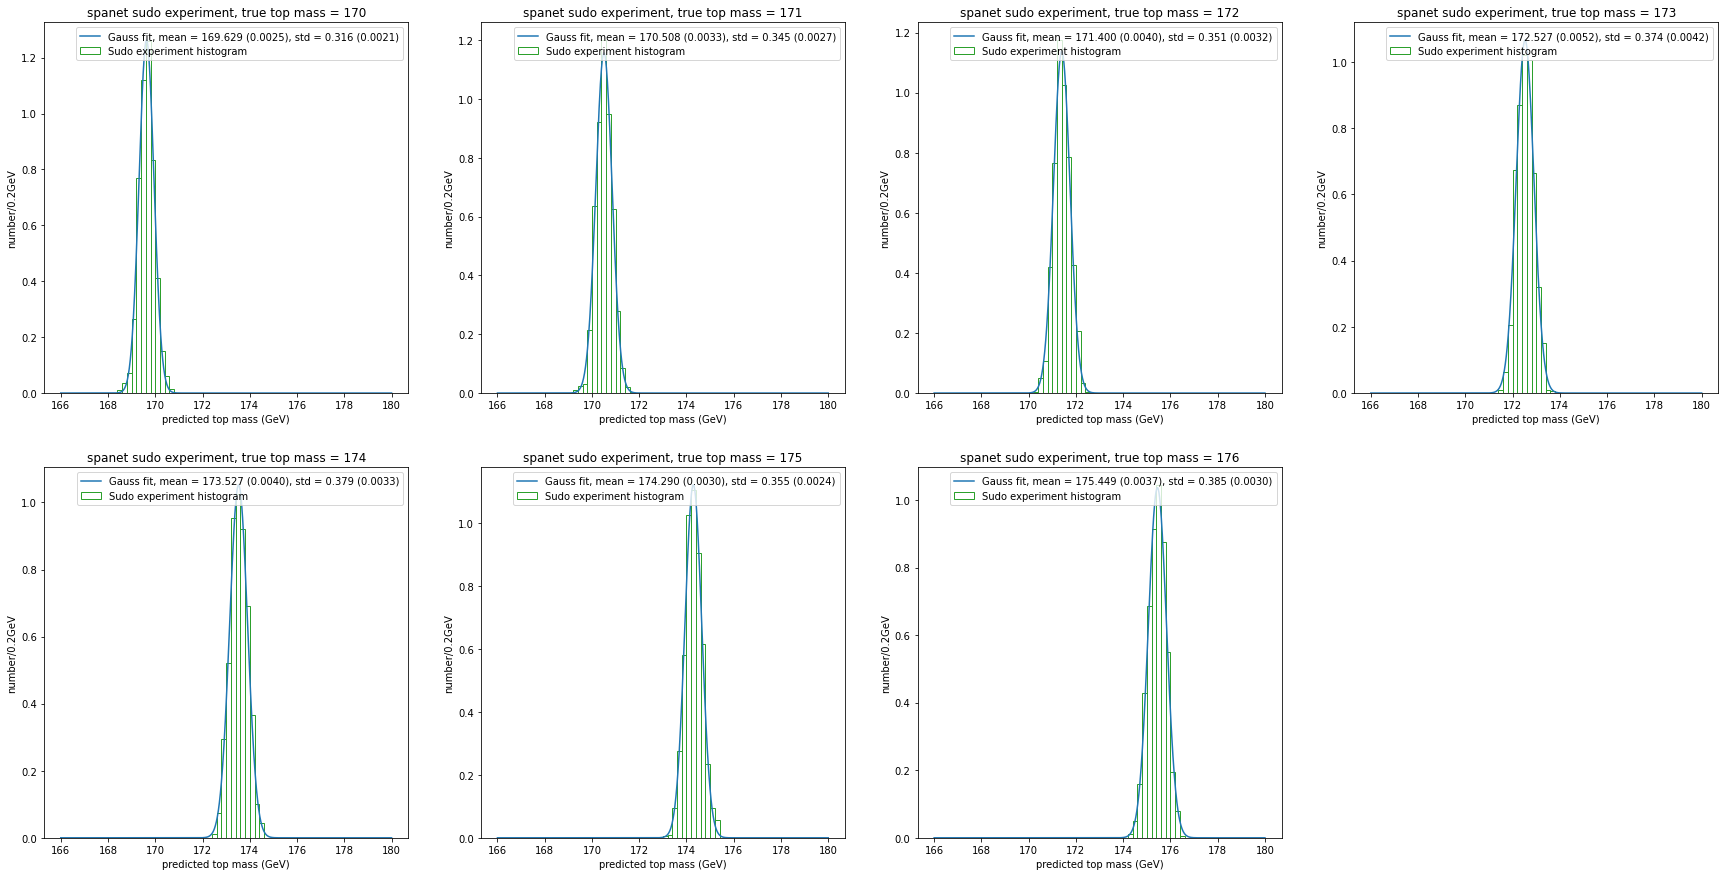

In [45]:
plt.figure(figsize=(30, 15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    hist, _ = np.histogram(sudo_spanet_mean_dic[m], bins=sudo_bins, density=True)
    popt, pcov = optimize.curve_fit(gau_norm, sudo_bins[:-1]+0.1, hist, p0 = (170, 2))
    perr = np.sqrt(np.diag(pcov))
    plt.plot(sudo_bins_dense, gau_norm(sudo_bins_dense, *popt), label = 'Gauss fit, mean = {:.3f} ({:.4f}), std = {:.3f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
    plt.bar(sudo_bins[:-1]+0.1, hist, edgecolor=colors[2], width=0.2, color='None', label = 'Sudo experiment histogram')
    plt.title('spanet sudo experiment, true top mass = {}'.format(m))
    plt.xlabel('predicted top mass (GeV)')
    plt.ylabel('number/0.2GeV')
    plt.legend(loc='upper right')
plt.savefig('./plots_topmass/spanet_sudo_experiment.png')
plt.show()

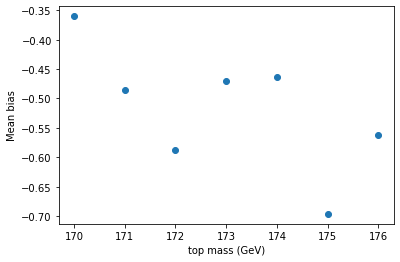

bias: -0.5182


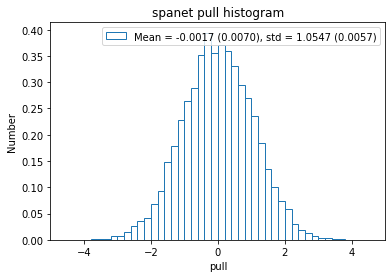

173.00468268268267, (0.08408408408408263)


In [46]:
plt.scatter(mass, [np.mean(sudo_spanet_mean_dic[m])-m for m in mass])
plt.xlabel('top mass (GeV)')
plt.ylabel('Mean bias')
plt.savefig('./plots_topmass/spanet_bias.png')
plt.show()

spanet_bias = np.mean([np.mean(sudo_spanet_mean_dic[m])-m for m in mass])
print('bias: {:.4f}'.format(spanet_bias))

pull_spanet = []
for m in mass:
    pull_spanet.extend((np.array(sudo_spanet_mean_dic[m])-m-spanet_bias)/np.array(sudo_spanet_variace_dic[m]))
hist, bin_edges = np.histogram(pull_spanet, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor=colors[state_i], width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
plt.title('spanet pull histogram')
plt.xlabel('pull')
plt.ylabel('Number')
plt.xlim(-5, 5)
plt.legend(loc='upper right')
plt.savefig('./plots_topmass/spanet_pull.png')
plt.show()
print('{}, ({})'.format(spanet_top_mass - spanet_bias, spanet_top_mass_std))

In [47]:
reco_klf = reco_klf_dic[173][np.logical_and.reduce((cut_klf_dic[173], loglikeli_klf_dic[173]>loglikeli_cut))]
chi2_klf_arr = [chi2_pdf(reco_klf, combine_klf_pdf_func(bins[:-1]+bins_w/2, m)) for m in top_mass_dense]
reco_spanet = reco_spanet_dic[173][np.logical_and.reduce((cut_spanet_dic[173], marginal_spanet_dic[173]>marginal_prob_cut))]
chi2_spanet_arr = [chi2_pdf(reco_spanet, combine_spanet_pdf_func(bins[:-1]+bins_w/2, m)) for m in top_mass_dense]

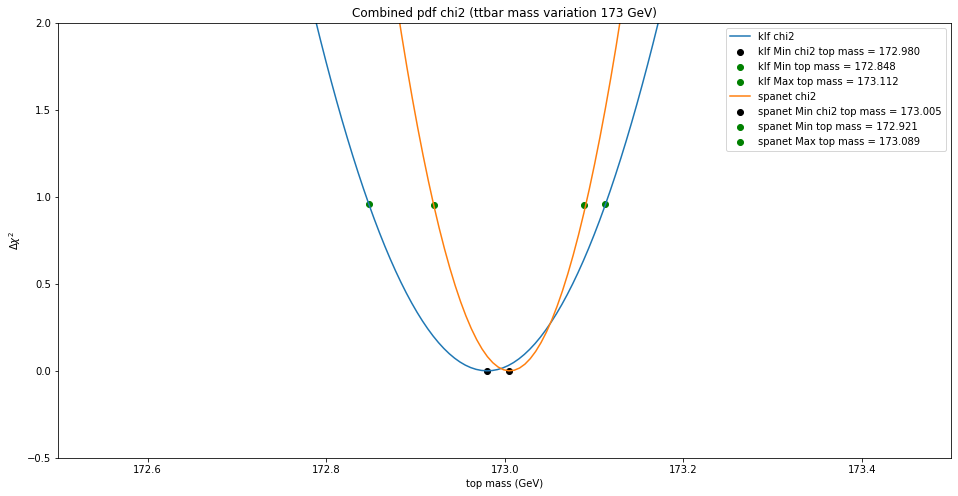

In [48]:
plt.figure(figsize=(16, 8))

# Plot klfitter chi2 - top mass plot
loglikeli_klf_min = min(chi2_klf_arr)
plt.plot(top_mass_dense - klf_bias, chi2_klf_arr-loglikeli_klf_min, label='klf chi2')
min_loc = [top_mass_dense[np.argmin(chi2_klf_arr)], loglikeli_klf_min]
passed_chi2_klf_arr = [chi2 for chi2 in chi2_klf_arr if chi2 < loglikeli_klf_min+1]
plt.scatter(min_loc[0] - klf_bias, min_loc[1]-loglikeli_klf_min, c='k', label = 'klf Min chi2 top mass = {:.3f}'.format(min_loc[0] -klf_bias))
plt.scatter(top_mass_dense[chi2_klf_arr.index(passed_chi2_klf_arr[0])] - klf_bias, passed_chi2_klf_arr[0]-loglikeli_klf_min, c='g', label='klf Min top mass = {:.3f}'.format(top_mass_dense[chi2_klf_arr.index(passed_chi2_klf_arr[0])] -klf_bias))
plt.scatter(top_mass_dense[chi2_klf_arr.index(passed_chi2_klf_arr[-1])] - klf_bias, passed_chi2_klf_arr[0]-loglikeli_klf_min, c='g', label='klf Max top mass = {:.3f}'.format(top_mass_dense[chi2_klf_arr.index(passed_chi2_klf_arr[-1])] -klf_bias))

klf_top_mass = min_loc[0]
klf_top_mass_std = (top_mass_dense[chi2_klf_arr.index(passed_chi2_klf_arr[-1])] - top_mass_dense[chi2_klf_arr.index(passed_chi2_klf_arr[0])])/2
# Plot spanet chi2 - top mass plot
loglikeli_spanet_min = min(chi2_spanet_arr)
plt.plot(top_mass_dense - spanet_bias, chi2_spanet_arr-loglikeli_spanet_min, label='spanet chi2')
min_loc = [top_mass_dense[np.argmin(chi2_spanet_arr)], min(chi2_spanet_arr)]
passed_chi2_spanet_arr = [chi2 for chi2 in chi2_spanet_arr if chi2 < min(chi2_spanet_arr)+1]
plt.scatter(min_loc[0] - spanet_bias, min_loc[1]-loglikeli_spanet_min, c='k', label = 'spanet Min chi2 top mass = {:.3f}'.format(min_loc[0] - spanet_bias))
plt.scatter(top_mass_dense[chi2_spanet_arr.index(passed_chi2_spanet_arr[0])] - spanet_bias, passed_chi2_spanet_arr[0]-loglikeli_spanet_min, c='g', label='spanet Min top mass = {:.3f}'.format(top_mass_dense[chi2_spanet_arr.index(passed_chi2_spanet_arr[0])] - spanet_bias))
plt.scatter(top_mass_dense[chi2_spanet_arr.index(passed_chi2_spanet_arr[-1])] - spanet_bias, passed_chi2_spanet_arr[0]-loglikeli_spanet_min, c='g', label='spanet Max top mass = {:.3f}'.format(top_mass_dense[chi2_spanet_arr.index(passed_chi2_spanet_arr[-1])] - spanet_bias))

spanet_top_mass = min_loc[0]
spanet_top_mass_std = (top_mass_dense[chi2_spanet_arr.index(passed_chi2_spanet_arr[-1])] - top_mass_dense[chi2_spanet_arr.index(passed_chi2_spanet_arr[0])])/2

plt.title('Combined pdf chi2 (ttbar mass variation 173 GeV)')
plt.xlabel('top mass (GeV)')
plt.ylabel(r'$\Delta \chi^2$')
plt.xlim(172.5, 173.5)
plt.ylim(-0.5, 2)
plt.legend(loc='upper right')
plt.savefig('./plots_topmass/chi2.png')
plt.show()